# Noise experiments

In [1]:
import numpy as np
import mnist
import os
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from components.cnn_parallell import experiment1, experiment2, experiment4, experiment6, experiment7, experiment8, experiment4_img_neg, experiment6_img_neg, experiment7_img_neg, experiment8_img_neg
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from components.cnn_score import score_clfs_noisy
from sklearn.neighbors import KNeighborsClassifier


In [2]:
def save_coefficients(path: str, data: np.ndarray, exp: str):
    folder = f"coefficients/{path}"
    os.makedirs(folder, exist_ok=True)

    file = f"{folder}/{exp}.npy"
    np.save(file, data)
    print(f"{file} saved")

def load_coefficients(path: str, exp: str):
    folder = f"coefficients/{path}"
    file = np.load(f"{folder}/{exp}.npy")
    return file

In [3]:
plt.rcParams["figure.figsize"] = (4,3)

In [4]:
train_imgs = mnist.train_images()/255.0
train_labels = mnist.train_labels()
test_imgs = mnist.test_images()/255.0
test_labels = mnist.test_labels()

data_train = train_imgs[:, 1:, 1:]
data_test = test_imgs[:, 1:, 1:]

In [5]:
noises = [.0, .1, .2, .3, .4, .5]

noisy_test = [np.array([img + np.random.normal(.0, noise, size=(data_test[0].shape)) for img in data_test]) for noise in noises]
noisy_test_flattened = [data.reshape(-1, 27*27) for data in noisy_test]

train_flattened = data_train.reshape(-1, 27*27)

experiments = [
    "Baseline - no threshold",
    "Baseline - 0.7 threshold",
    "Baseline - 0.85 threshold",
    "Experiment 1 - 1 ring",
    "Experiment 2 - 2 rings",
    "Experiment 4 - 3 rings",
    "Experiment 6 - 3 rings + 0.85 threshold",
    "Experiment 7 - Various grid configurations",
    "Experiment 8 - Various grud configurations + 0.85 threshold"
]

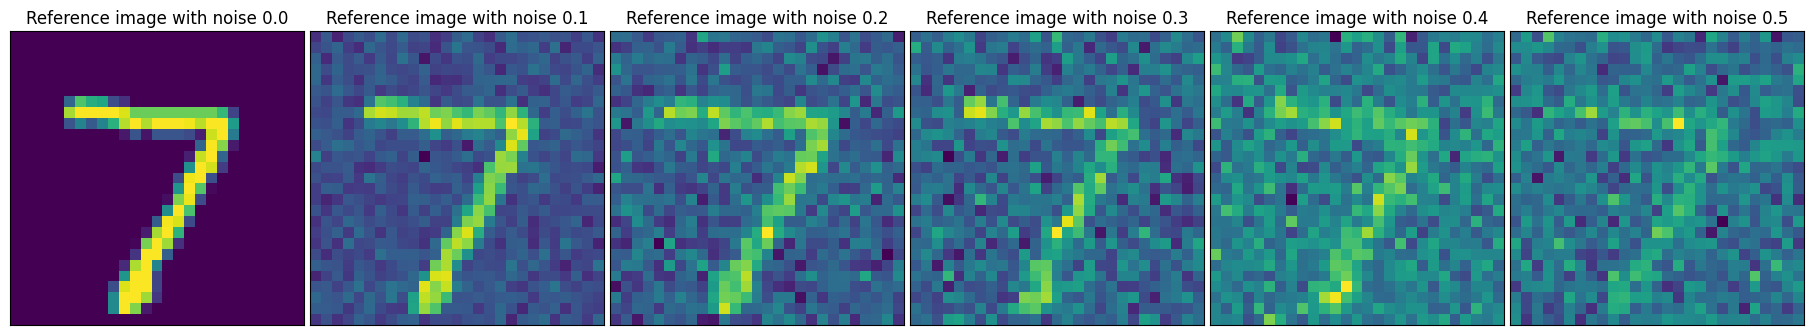

In [7]:
fig, ax = plt.subplots(1, len(noises), figsize=(18, 3))
for i in range(len(noises)): 
    ax[i].imshow(noisy_test[i][0])
    ax[i].set_xticks(())
    ax[i].set_yticks(())
    ax[i].set_title(f"Reference image with noise {noises[i]}")
plt.tight_layout(pad=0.0)


## Comparing performance on noisy mnist

In [6]:
lr_best_tols = {
    "baseline": 0.01,
    "exp1": 0.001,
    "exp2": 0.001,
    "exp4": 0.0005,
    "exp6": 0.005,
    "exp7": 0.005,
    "exp8": 0.005
}

scores_noisy_lr = []

### Logistic regression

#### Baseline - LR - No thresholding

In [8]:
clfs_bl = [LogisticRegression(fit_intercept=True,
                              multi_class='multinomial',
                              penalty='l2',
                              solver='saga',
                              max_iter=1000,
                              n_jobs=64,
                              tol=lr_best_tols["baseline"]) for _ in range(len(noises))]
baseline_lr_scores = score_clfs_noisy(clfs_bl, train_flattened, train_labels, noisy_test_flattened, test_labels)
scores_noisy_lr.append(baseline_lr_scores)
baseline_lr_scores

[0.9263, 0.9121, 0.8613, 0.7835, 0.6998, 0.6096]

In [17]:
#scores_noisy_lr.append([0.926, 0.9087, 0.8632, 0.7841, 0.6935, 0.6186])

Text(3.972222222222223, 0.5, 'Accuracy score')

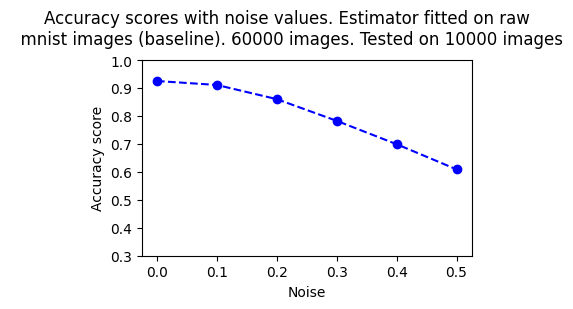

In [9]:
plt.plot([str(t) for t in noises], baseline_lr_scores, linestyle='--', marker='o', color='b', label='Accuracy score')
plt.tight_layout(rect=(0., 0.03, 1., 0.86))
plt.suptitle(f"Accuracy scores with noise values. Estimator fitted on raw\n  mnist images (baseline). {data_train.shape[0]} images. Tested on {data_test.shape[0]} images")
plt.ylim([.3, 1.])
plt.xlabel("Noise") 
plt.ylabel("Accuracy score") 

#### Baseline - LR - 0.7 thresholding

In [10]:
train_flattened_threshold1 = np.where(train_flattened > 0.7, train_flattened, 0.)
noisy_test_flattened_threshold1 = [np.where(n > 0.7, n, 0.) for n in noisy_test_flattened]

train_flattened_threshold2 = np.where(train_flattened > 0.85, train_flattened, 0.)
noisy_test_flattened_threshold2 = [np.where(n > 0.85, n, 0.) for n in noisy_test_flattened]

In [10]:
clfs_bl_threshold1 = [LogisticRegression(fit_intercept=True,
                                         multi_class='multinomial',
                                         penalty='l2',
                                         solver='saga',
                                         max_iter=1000,
                                         n_jobs=64,
                                         tol=lr_best_tols["baseline"]) for _ in range(len(noises))]

train_flattened_threshold1 = np.where(train_flattened > 0.7, train_flattened, 0.)
noisy_test_flattened_threshold1 = [np.where(n > 0.7, n, 0.) for n in noisy_test_flattened]

baseline_lr_scores_1 = score_clfs_noisy(clfs_bl_threshold1, train_flattened_threshold1, train_labels, noisy_test_flattened_threshold1, test_labels)
scores_noisy_lr.append(baseline_lr_scores_1)
baseline_lr_scores_1

[0.9158, 0.9142, 0.9006, 0.8712, 0.7518, 0.5687]

In [18]:
#scores_noisy_lr.append([0.9161, 0.9135, 0.9015, 0.8683, 0.7431, 0.5776])

#### Baseline - LR - 0.85 thresholding

In [11]:
clfs_bl_threshold2 = [LogisticRegression(fit_intercept=True,
                                         multi_class='multinomial',
                                         penalty='l2',
                                         solver='saga',
                                         max_iter=1000,
                                         n_jobs=64,
                                         tol=lr_best_tols["baseline"]) for _ in range(len(noises))]

baseline_lr_scores_2 = score_clfs_noisy(clfs_bl_threshold2, train_flattened_threshold2, train_labels, noisy_test_flattened_threshold2, test_labels)
scores_noisy_lr.append(baseline_lr_scores_2)
baseline_lr_scores_2

[0.9035, 0.8971, 0.8719, 0.8533, 0.7875, 0.6444]

In [19]:
#scores_noisy_lr.append([0.9037, 0.8928, 0.8758, 0.8535, 0.7882, 0.6447])

#### Experiment 1 - LR

In [14]:
""" exp_1_train_transformed = experiment1(data_train)
exp_1_test_transformed = [experiment1(test) for test in noisy_test] """

exp_1_train_transformed = load_coefficients("train", "experiment_1_train")
exp_1_test_transformed = [load_coefficients("test/experiment1", f"noise_test_{i}") for i in range(len(noises))]

In [13]:
save_coefficients("train", exp_1_train_transformed, "experiment_1_train")
[save_coefficients("test/experiment1", t, f"noise_test_{i}") for i, t in enumerate(exp_1_test_transformed)]

coefficients/train/experiment_1_train.npy saved
coefficients/test/experiment1/noise_test_0.npy saved
coefficients/test/experiment1/noise_test_1.npy saved
coefficients/test/experiment1/noise_test_2.npy saved
coefficients/test/experiment1/noise_test_3.npy saved
coefficients/test/experiment1/noise_test_4.npy saved
coefficients/test/experiment1/noise_test_5.npy saved


[None, None, None, None, None, None]

In [14]:
clfs_lr_ex1 = [LogisticRegression(fit_intercept=True,
                           multi_class='multinomial',
                           penalty='l2',
                           solver='saga',
                           max_iter=1000,
                           n_jobs=64,
                           tol=lr_best_tols["exp1"]) for _ in range(len(noises))]

lr_noisy_exp2_score = score_clfs_noisy(clfs_lr_ex1, exp_1_train_transformed, train_labels, exp_1_test_transformed, test_labels)                        
scores_noisy_lr.append(lr_noisy_exp2_score)
lr_noisy_exp2_score

[0.9238, 0.898, 0.8651, 0.8043, 0.696, 0.5577]

In [22]:
#scores_noisy_lr.append([0.9238, 0.8987, 0.8651, 0.806, 0.7003, 0.5716])

#### Experiment 2 - LR

In [15]:
""" exp_2_train_transformed = experiment2(data_train)
exp_2_test_transformed = [experiment2(test) for test in noisy_test] """

exp_2_train_transformed = load_coefficients("train", "experiment_2_train")
exp_2_test_transformed = [load_coefficients("test/experiment2", f"noise_test_{i}") for i in range(len(noises))]

In [16]:
save_coefficients("train", exp_2_train_transformed, "experiment_2_train")
[save_coefficients("test/experiment2", t, f"noise_test_{i}") for i, t in enumerate(exp_2_test_transformed)]

coefficients/train/experiment_2_train.npy saved
coefficients/test/experiment2/noise_test_0.npy saved
coefficients/test/experiment2/noise_test_1.npy saved
coefficients/test/experiment2/noise_test_2.npy saved
coefficients/test/experiment2/noise_test_3.npy saved
coefficients/test/experiment2/noise_test_4.npy saved
coefficients/test/experiment2/noise_test_5.npy saved


[None, None, None, None, None, None]

In [17]:
clfs_lr_ex2 = [LogisticRegression(fit_intercept=True,
                                  multi_class='multinomial',
                                  penalty='l2',
                                  solver='saga',
                                  max_iter=1000,
                                  n_jobs=64,
                                  tol=lr_best_tols["exp2"]) for _ in range(len(noises))]

lr_noisy_exp2_score = score_clfs_noisy(clfs_lr_ex2, exp_2_train_transformed, train_labels, exp_2_test_transformed, test_labels)                        
scores_noisy_lr.append(lr_noisy_exp2_score)
lr_noisy_exp2_score

[0.9461, 0.739, 0.6828, 0.5918, 0.4792, 0.3758]

In [26]:
scores_noisy_lr.append([0.9461, 0.7513, 0.6833, 0.594, 0.4706, 0.3755])

### Experiment 4 - LR

In [16]:
""" exp_4_train_transformed = experiment4(data_train)
exp_4_test_transformed = [experiment4(test) for test in noisy_test] """

exp_4_train_transformed = load_coefficients("train", "experiment_4_train")
exp_4_test_transformed = [load_coefficients("test/experiment4", f"noise_test_{i}") for i in range(len(noises))]

In [19]:
clfs_lr_ex4 = [LogisticRegression(fit_intercept=True,
                                  multi_class='multinomial',
                                  penalty='l2',
                                  solver='saga',
                                  max_iter=1000,
                                  n_jobs=64,
                                  tol=lr_best_tols["exp4"]) for _ in range(len(noises))]

lr_noisy_exp4_score = score_clfs_noisy(clfs_lr_ex4, exp_4_train_transformed, train_labels, exp_4_test_transformed, test_labels)
scores_noisy_lr.append(lr_noisy_exp4_score)
lr_noisy_exp4_score

[0.9713, 0.7988, 0.746, 0.6734, 0.5682, 0.4428]

In [20]:
save_coefficients("train", exp_4_train_transformed, "experiment_4_train")
[save_coefficients("test/experiment4", t, f"noise_test_{i}") for i, t in enumerate(exp_4_test_transformed)]

coefficients/train/experiment_4_train.npy saved
coefficients/test/experiment4/noise_test_0.npy saved
coefficients/test/experiment4/noise_test_1.npy saved
coefficients/test/experiment4/noise_test_2.npy saved
coefficients/test/experiment4/noise_test_3.npy saved
coefficients/test/experiment4/noise_test_4.npy saved
coefficients/test/experiment4/noise_test_5.npy saved


[None, None, None, None, None, None]

In [29]:
scores_noisy_lr.append([0.9713, 0.7984, 0.7507, 0.6748, 0.5664, 0.4406])

### Experiment 6 - LR

In [17]:
""" exp_6_train_transformed = experiment6(data_train, threshold=0.85)
exp_6_test_transformed = [experiment6(test, threshold=0.85) for test in noisy_test] """

exp_6_train_transformed = load_coefficients("train", "experiment_6_train")
exp_6_test_transformed = [load_coefficients("test/experiment6", f"noise_test_{i}") for i in range(len(noises))]

In [22]:
clfs_lr_ex6 = [LogisticRegression(fit_intercept=True,
                                  multi_class='multinomial',
                                  penalty='l2',
                                  solver='saga',
                                  max_iter=1000,
                                  n_jobs=64,
                                  tol=lr_best_tols["exp6"]) for _ in range(len(noises))]

lr_noisy_exp6_score = score_clfs_noisy(clfs_lr_ex6, exp_6_train_transformed, train_labels, exp_6_test_transformed, test_labels)
scores_noisy_lr.append(lr_noisy_exp6_score)
lr_noisy_exp6_score

[0.9306, 0.9279, 0.9034, 0.8211, 0.5596, 0.2914]

In [23]:
scores_noisy_lr.append([0.9305, 0.9254, 0.9071, 0.818, 0.5687, 0.2882])

In [43]:
save_coefficients("train", exp_6_train_transformed, "experiment_6_train")
[save_coefficients("test/experiment6", t, f"noise_test_{i}") for i, t in enumerate(exp_6_test_transformed)]

coefficients/train/experiment_6_train.npy saved
coefficients/test/experiment6/noise_test_0.npy saved
coefficients/test/experiment6/noise_test_1.npy saved
coefficients/test/experiment6/noise_test_2.npy saved
coefficients/test/experiment6/noise_test_3.npy saved
coefficients/test/experiment6/noise_test_4.npy saved
coefficients/test/experiment6/noise_test_5.npy saved


[None, None, None, None, None, None]

### Experiment 7 - LR

In [18]:
""" exp_7_train_transformed = experiment7(data_train, grids=[(3, 3), (2, 5), (1, 7)])
exp_7_test_transformed = [experiment7(test, grids=[(3, 3), (2, 5), (1, 7)]) for test in noisy_test] """

exp_7_train_transformed = load_coefficients("train", "experiment_7_train")
exp_7_test_transformed = [load_coefficients("test/experiment7", f"noise_test_{i}") for i in range(len(noises))]

In [25]:
clfs_lr_ex7 = [LogisticRegression(fit_intercept=True,
                                  multi_class='multinomial',
                                  penalty='l2',
                                  solver='saga',
                                  max_iter=1000,
                                  n_jobs=64,
                                  tol=lr_best_tols["exp7"]) for _ in range(len(noises))]

lr_noisy_exp7_score = score_clfs_noisy(clfs_lr_ex7, exp_7_train_transformed, train_labels, exp_7_test_transformed, test_labels)
scores_noisy_lr.append(lr_noisy_exp7_score)
lr_noisy_exp7_score

[0.9749, 0.9242, 0.8927, 0.8408, 0.7761, 0.6952]

In [38]:
scores_noisy_lr.append([0.9583, 0.9089, 0.8724, 0.8264, 0.7702, 0.7155])

In [104]:
save_coefficients("train", exp_7_train_transformed, "experiment_7_train")
[save_coefficients("test/experiment7", t, f"noise_test_{i}") for i, t in enumerate(exp_7_test_transformed)]

coefficients/train/experiment_7_train.npy saved
coefficients/test/experiment7/noise_test_0.npy saved
coefficients/test/experiment7/noise_test_1.npy saved
coefficients/test/experiment7/noise_test_2.npy saved
coefficients/test/experiment7/noise_test_3.npy saved
coefficients/test/experiment7/noise_test_4.npy saved
coefficients/test/experiment7/noise_test_5.npy saved


[None, None, None, None, None, None]

### Experiment 8 - LR

In [19]:
""" exp_8_train_transformed = experiment8(data_train, threshold=0.7, grids=[(3, 3), (2, 5), (1, 7)])
exp_8_test_transformed = [experiment8(test, threshold=0.7, grids=[(3, 3), (2, 5), (1, 7)]) for test in noisy_test] """

exp_8_train_transformed = load_coefficients("train", "experiment_8_train")
exp_8_test_transformed = [load_coefficients("test/experiment8", f"noise_test_{i}") for i in range(len(noises))]

In [28]:
clfs_lr_ex8 = [LogisticRegression(fit_intercept=True,
                                  multi_class='multinomial',
                                  penalty='l2',
                                  solver='saga',
                                  max_iter=1000,
                                  n_jobs=64,
                                  tol=0.001) for _ in range(len(noises))]

lr_noisy_exp8_score = score_clfs_noisy(clfs_lr_ex8, exp_8_train_transformed, train_labels, exp_8_test_transformed, test_labels)
scores_noisy_lr.append(lr_noisy_exp8_score)
lr_noisy_exp8_score

[0.9575, 0.9536, 0.9347, 0.8475, 0.6102, 0.3513]

In [106]:
save_coefficients("train", exp_8_train_transformed, "experiment_8_train")
[save_coefficients("test/experiment8", t, f"noise_test_{i}") for i, t in enumerate(exp_8_test_transformed)]

coefficients/train/experiment_8_train.npy saved
coefficients/test/experiment8/noise_test_0.npy saved
coefficients/test/experiment8/noise_test_1.npy saved
coefficients/test/experiment8/noise_test_2.npy saved
coefficients/test/experiment8/noise_test_3.npy saved
coefficients/test/experiment8/noise_test_4.npy saved
coefficients/test/experiment8/noise_test_5.npy saved


[None, None, None, None, None, None]

In [39]:
scores_noisy_lr.append([0.9791, 0.933, 0.8832, 0.8353, 0.7629, 0.6705])

### Results from LR

Text(0.5, 0.98, 'Trained on MNIST with LR estimator, tested on noisy images. \nTrained on 60000 images. Tested on 10000 images')

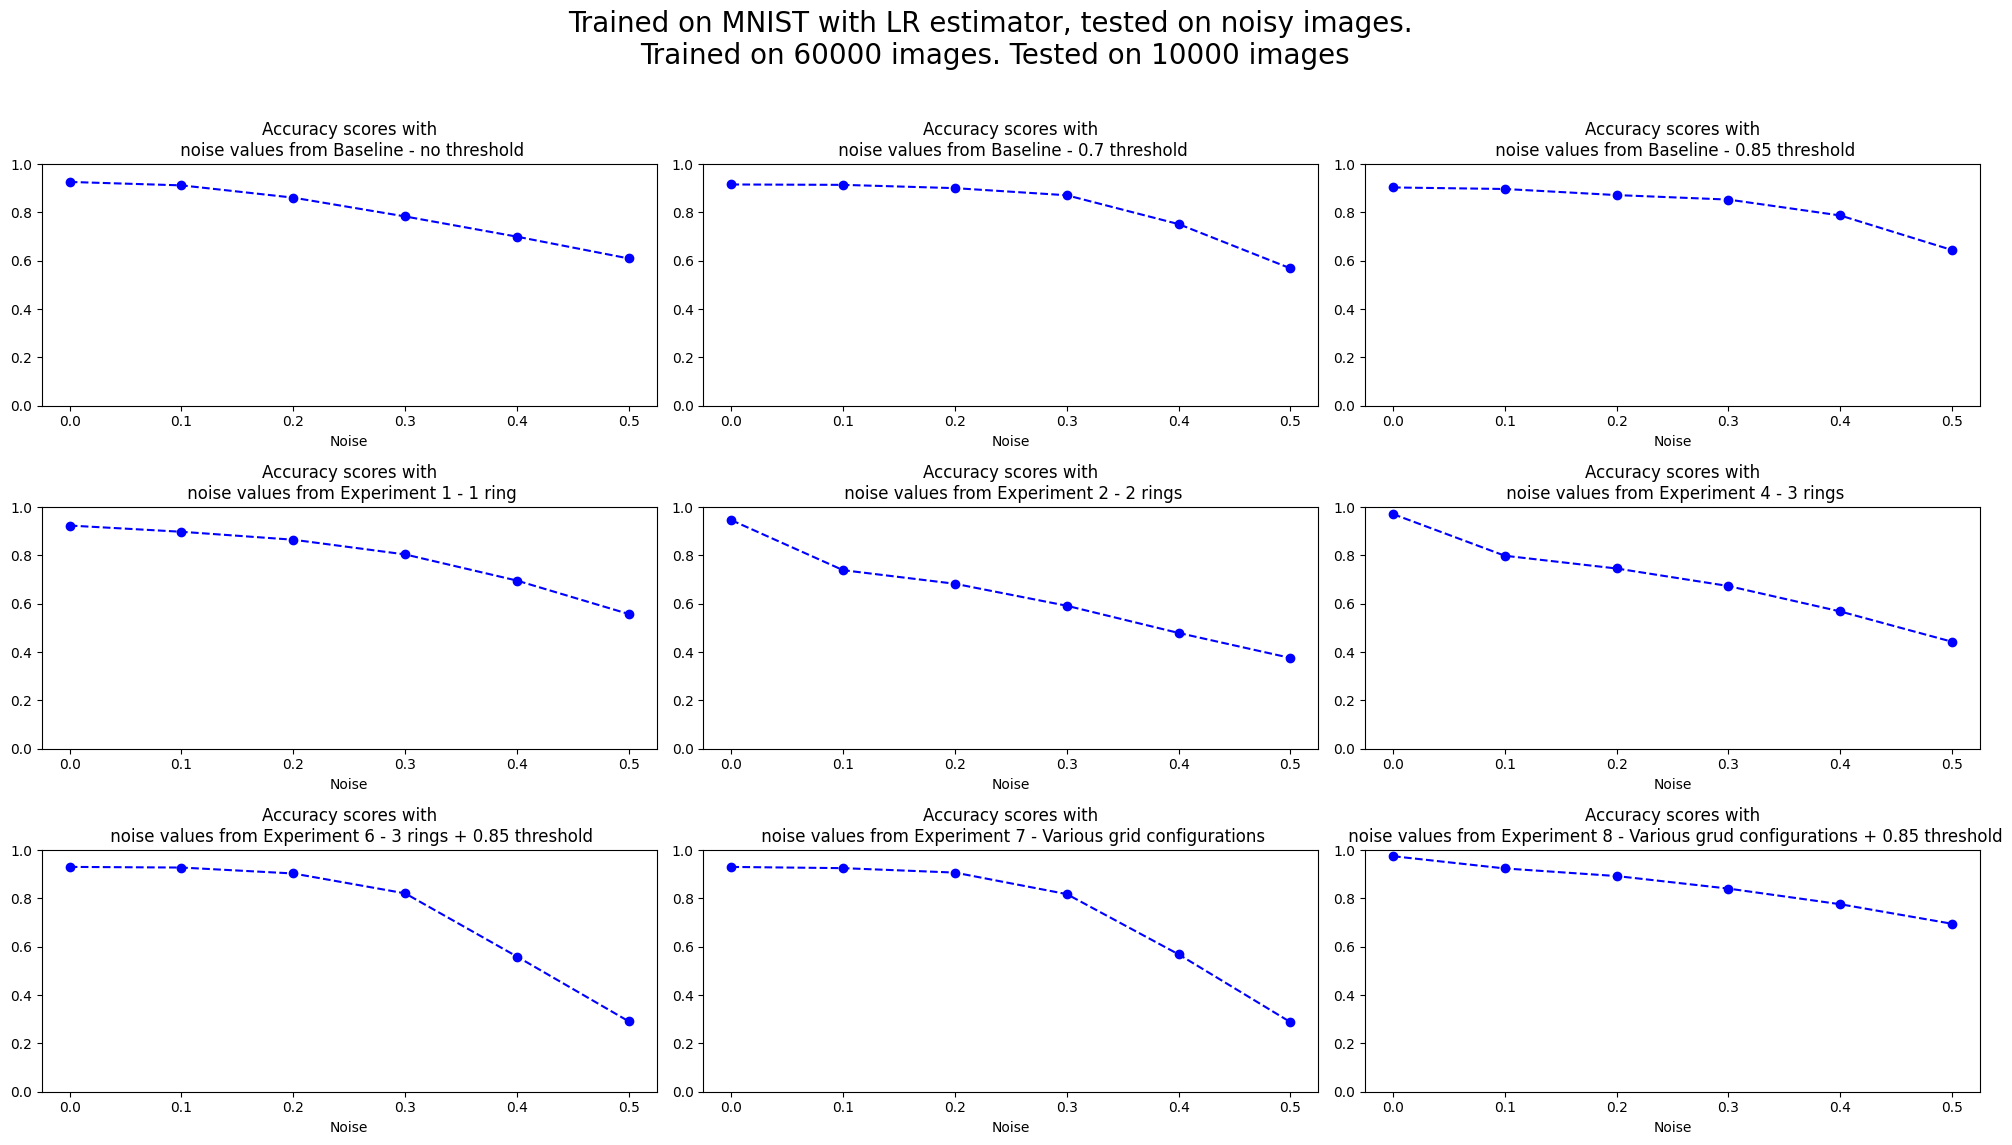

In [30]:
fig, ax = plt.subplots(3, 3, figsize=(20, 12))
for i in range(9):
    k, j = i // 3, i % 3
    ax[k][j].plot([str(t) for t in noises], scores_noisy_lr[i], linestyle='--', marker='o', color='b', label='Accuracy score')
    ax[k][j].set_title(f"Accuracy scores with\n noise values from {experiments[i]}")
    ax[k][j].set_ylim([.0, 1.])
    ax[k][j].set_xlabel("Noise") 
fig.tight_layout(rect=(0., 0.03, 1., 0.9))
fig.suptitle(f"Trained on MNIST with LR estimator, tested on noisy images. \nTrained on {data_train.shape[0]} images. Tested on {data_test.shape[0]} images",
             fontsize=20)
#fig.delaxes(ax[1,3])

### SVM

In [30]:
svm_best_Cs = {
    "baseline": 10.,
    "exp1": 500.,
    "exp2": 500.,
    "exp3": 500.,
    "exp4": 500.,
    "exp5": 500.,
    "exp6": 10.,
    "exp7": 10.,
    "exp8": 10.
}

scores_noisy_svm = []

#### Baseline - SVM - No thresholding

In [32]:
clfs_svm_bl = [SVC(kernel='rbf', C=svm_best_Cs["baseline"], gamma="auto") for _ in range(len(noises))]
baseline_svm_scores = score_clfs_noisy(clfs_svm_bl, train_flattened, train_labels, noisy_test_flattened, test_labels)
scores_noisy_svm.append(baseline_svm_scores)
baseline_svm_scores

[0.9624, 0.9603, 0.9444, 0.9009, 0.8035, 0.7063]

In [42]:
scores_noisy_svm.append([0.9624, 0.9615, 0.9477, 0.8996, 0.8081, 0.7028])

[0.9615, 0.9477, 0.8996, 0.8081, 0.7028]

#### Baseline - SVM - 0.7 threshold

In [33]:
clfs_svm_bl_thr1 = [SVC(kernel='rbf', C=svm_best_Cs["baseline"], gamma="auto") for _ in range(len(noises))]

baseline_svm_scores_thr1 = score_clfs_noisy(clfs_svm_bl_thr1, train_flattened_threshold1, train_labels, noisy_test_flattened_threshold1, test_labels)
scores_noisy_svm.append(baseline_svm_scores_thr1)
baseline_svm_scores_thr1

[0.9503, 0.9501, 0.938, 0.9291, 0.8794, 0.7491]

In [45]:
scores_noisy_svm.append([0.9503, 0.9475, 0.9411, 0.9266, 0.8817, 0.7493])

#### Baseline - SVM - 0.85 threshold

In [34]:
clfs_svm_bl_thr2 = [SVC(kernel='rbf', C=svm_best_Cs["baseline"], gamma="auto") for _ in range(len(noises))]

train_flattened_threshold2 = np.where(train_flattened > 0.85, train_flattened, 0.)
noisy_test_flattened_threshold2 = [np.where(n > 0.85, n, 0.) for n in noisy_test_flattened]

baseline_svm_scores_thr2 = score_clfs_noisy(clfs_svm_bl_thr2, train_flattened_threshold2, train_labels, noisy_test_flattened_threshold2, test_labels)
scores_noisy_svm.append(baseline_svm_scores_thr2)
baseline_svm_scores_thr2

[0.9342, 0.9285, 0.9112, 0.8989, 0.8701, 0.7787]

In [46]:
scores_noisy_svm.append([0.9342, 0.929, 0.9116, 0.8996, 0.8715, 0.7758])

#### Experiment 1 - SVM

In [35]:
clfs_svm_exp1 = [SVC(kernel='rbf', C=svm_best_Cs["exp1"], gamma="auto") for _ in range(len(noises))]
scores_noisy_exp1_svm = score_clfs_noisy(clfs_svm_exp1, exp_1_train_transformed, train_labels, exp_1_test_transformed, test_labels)
scores_noisy_svm.append(scores_noisy_exp1_svm)
scores_noisy_exp1_svm

[0.9534, 0.9224, 0.887, 0.809, 0.6693, 0.5099]

In [47]:
scores_noisy_svm.append([0.9534, 0.9222, 0.8856, 0.8107, 0.6753, 0.5158])

[0.9222, 0.8856, 0.8107, 0.6753, 0.5158]

#### Experiment 2 - SVM

In [36]:
clfs_svm_exp2 = [SVC(kernel='rbf', C=svm_best_Cs["exp2"], gamma="auto") for _ in range(len(noises))]
scores_noisy_exp2_svm = score_clfs_noisy(clfs_svm_exp2, exp_2_train_transformed, train_labels, exp_2_test_transformed, test_labels)
scores_noisy_svm.append(scores_noisy_exp2_svm)
scores_noisy_exp2_svm

[0.9741, 0.6629, 0.6002, 0.4993, 0.3861, 0.2885]

In [48]:
scores_noisy_svm.append([0.9741, 0.6647, 0.6021, 0.5019, 0.378, 0.2879])

[0.6647, 0.6021, 0.5019, 0.378, 0.2879]

#### Experiment 4 - SVM

In [37]:
clfs_svm_exp4 = [SVC(kernel='rbf', C=svm_best_Cs["exp4"], gamma="auto") for _ in range(len(noises))]
scores_noisy_exp4_svm = score_clfs_noisy(clfs_svm_exp4, exp_4_train_transformed, train_labels, exp_4_test_transformed, test_labels)
scores_noisy_svm.append(scores_noisy_exp4_svm)
scores_noisy_exp4_svm

[0.9841, 0.7593, 0.7005, 0.5943, 0.4821, 0.3726]

In [49]:
scores_noisy_svm.append([0.9843, 0.7194, 0.6445, 0.5425, 0.4201, 0.3219])

[0.7194, 0.6445, 0.5425, 0.4201, 0.3219]

#### Experiment 6 - SVM

In [38]:
clfs_svm_exp6 = [SVC(kernel='rbf', C=svm_best_Cs["exp6"], gamma="auto") for _ in range(len(noises))]
scores_noisy_exp6_svm = score_clfs_noisy(clfs_svm_exp6, exp_6_train_transformed, train_labels, exp_6_test_transformed, test_labels)
scores_noisy_svm.append(scores_noisy_exp6_svm)
scores_noisy_exp6_svm

[0.9477, 0.9454, 0.9259, 0.8465, 0.6174, 0.3508]

In [50]:
scores_noisy_svm.append([0.9864, 0.9461, 0.9287, 0.838, 0.5989, 0.3432])

[0.9461, 0.9287, 0.838, 0.5989, 0.3432]

#### Experiment 7 - SVM

In [39]:
clfs_svm_exp7 = [SVC(kernel='rbf', C=500., gamma="auto") for _ in range(len(noises))]
scores_noisy_exp7_svm = score_clfs_noisy(clfs_svm_exp7, exp_7_train_transformed, train_labels, exp_7_test_transformed, test_labels)
scores_noisy_svm.append(scores_noisy_exp7_svm)
scores_noisy_exp7_svm

[0.9876, 0.9216, 0.8705, 0.7918, 0.683, 0.554]

In [51]:
scores_noisy_svm.append([0.9876, 0.9251, 0.8668, 0.7956, 0.6811, 0.5483])

[0.9251, 0.8668, 0.7956, 0.6811, 0.5483]

#### Experiment 8 - SVM

In [120]:
clfs_svm_exp8 = [SVC() for _ in range(len(noises))]
scores_noisy_exp8_svm = score_clfs_noisy(clfs_svm_exp8, exp_8_train_transformed, train_labels, exp_8_test_transformed, test_labels)
#scores_noisy_svm.append(scores_noisy_exp8_svm)
scores_noisy_exp8_svm

[0.9645, 0.9599, 0.9474, 0.9331, 0.9052, 0.8593]

In [117]:
scores_noisy_svm ##gamma 1 gave 0.82

[[0.9624, 0.9603, 0.9444, 0.9009, 0.8035, 0.7063],
 [0.9503, 0.9501, 0.938, 0.9291, 0.8794, 0.7491],
 [0.9342, 0.9285, 0.9112, 0.8989, 0.8701, 0.7787],
 [0.9534, 0.9224, 0.887, 0.809, 0.6693, 0.5099],
 [0.9741, 0.6629, 0.6002, 0.4993, 0.3861, 0.2885],
 [0.9841, 0.7593, 0.7005, 0.5943, 0.4821, 0.3726],
 [0.9477, 0.9454, 0.9259, 0.8465, 0.6174, 0.3508],
 [0.9876, 0.9216, 0.8705, 0.7918, 0.683, 0.554],
 [0.9648, 0.9485, 0.9256, 0.8974, 0.8647, 0.8014]]

### Results from SVM

Text(0.5, 0.98, 'Trained on MNIST with SVM estimator, tested on noisy images. \nTrained on 60000 images. Tested on 10000 images')

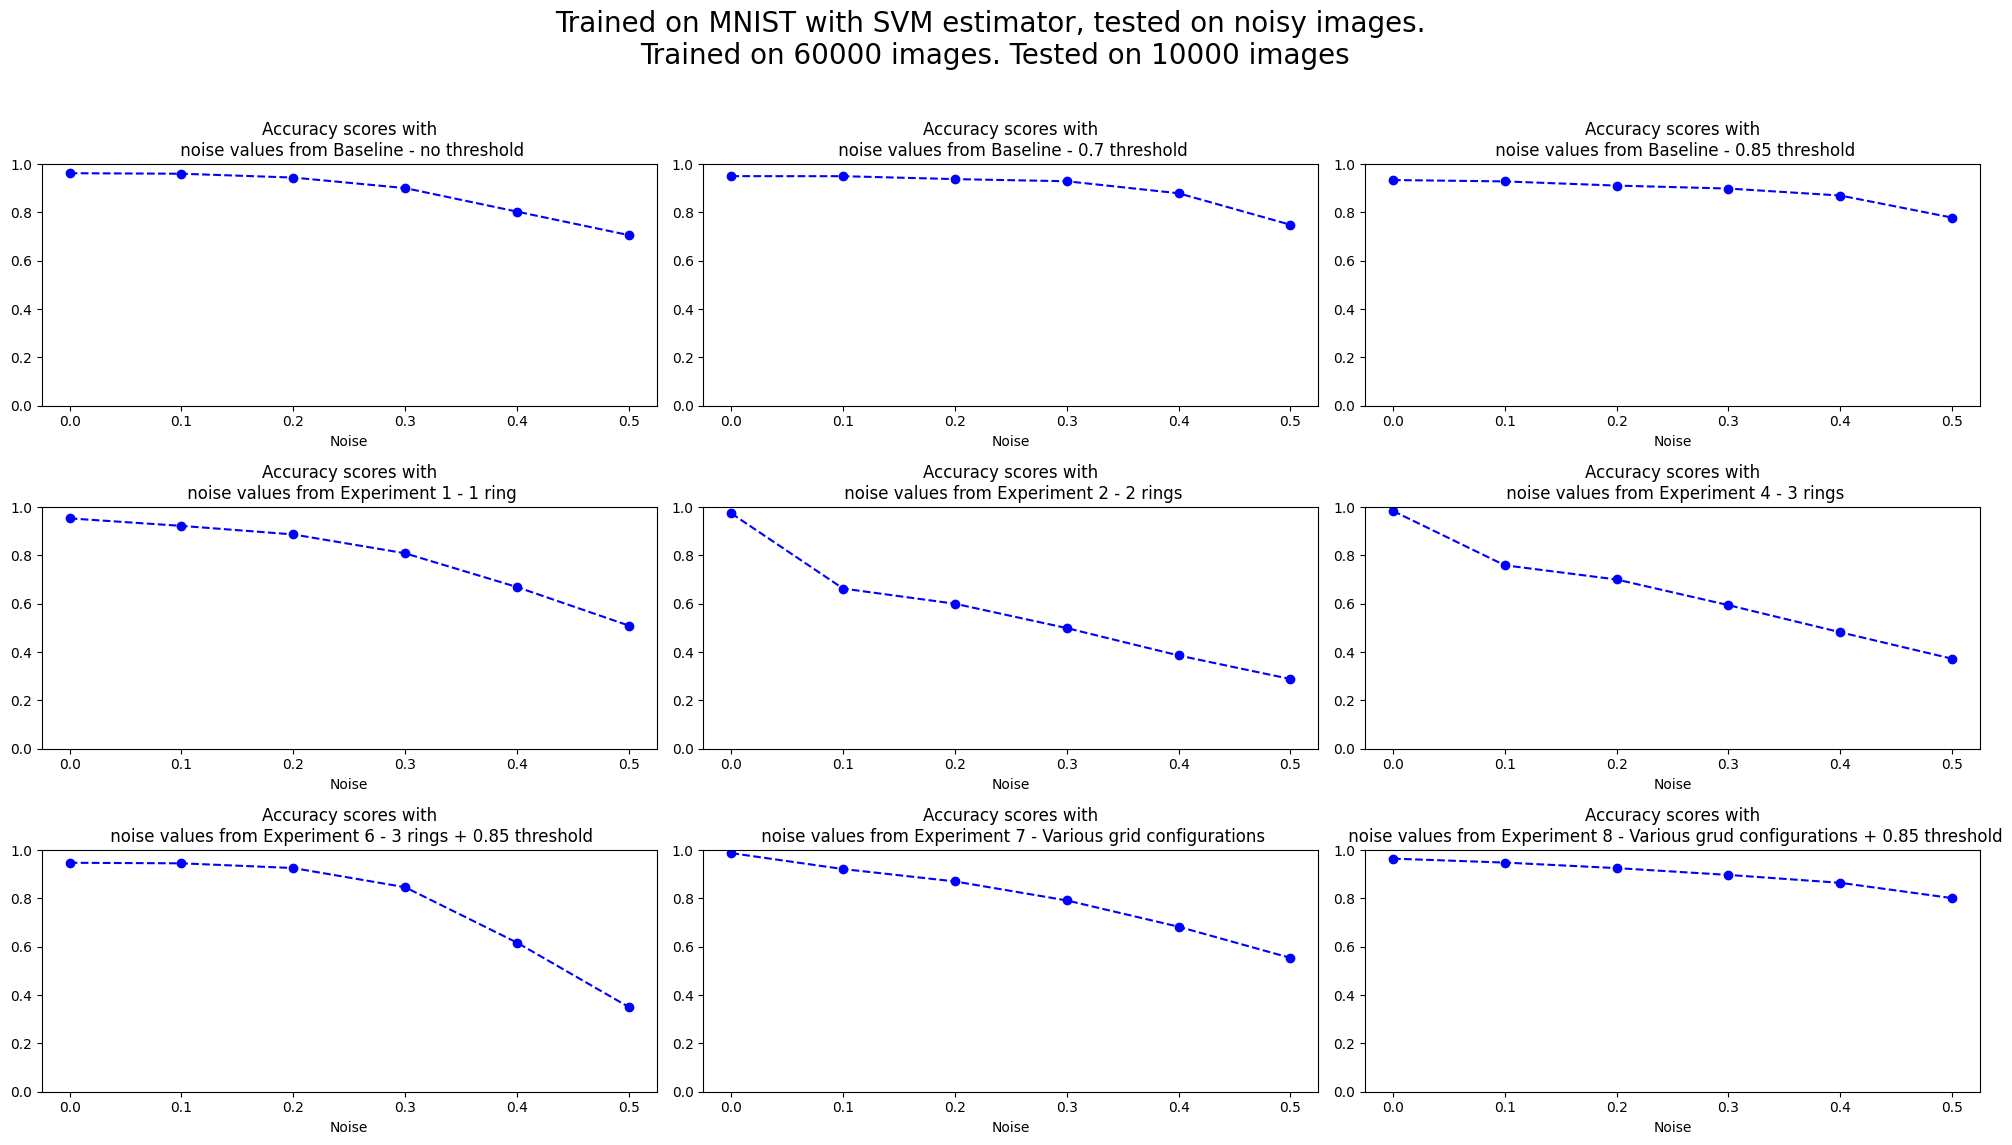

In [114]:
fig, ax = plt.subplots(3, 3, figsize=(20, 12))
for i in range(9):
    k, j = i // 3, i % 3
    ax[k][j].plot([str(t) for t in noises], scores_noisy_svm[i], linestyle='--', marker='o', color='b', label='Accuracy score')
    ax[k][j].set_title(f"Accuracy scores with\n noise values from {experiments[i]}")
    ax[k][j].set_ylim([.0, 1.])
    ax[k][j].set_xlabel("Noise") 
fig.tight_layout(rect=(0., 0.03, 1., 0.9))
fig.suptitle(f"Trained on MNIST with SVM estimator, tested on noisy images. \nTrained on {data_train.shape[0]} images. Tested on {data_test.shape[0]} images",
             fontsize=20)

#### KNN

In [28]:
scores_noisy_knn = []

#### Baseline - KNN - No thresholding

In [29]:
clfs_knn_bl = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
baseline_knn_scores = score_clfs_noisy(clfs_knn_bl, train_flattened, train_labels, noisy_test_flattened, test_labels)
scores_noisy_knn.append(baseline_knn_scores)
baseline_knn_scores

[0.9688, 0.9698, 0.9681, 0.9652, 0.9589, 0.9577]

In [63]:
scores_noisy_knn.append([0.9688, 0.9683, 0.9669, 0.9675, 0.9636, 0.9578])

#### Baseline - KNN - 0.7 threshold

In [30]:
clfs_knn_bl_thr1 = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
baseline_knn_scores_thr1 = score_clfs_noisy(clfs_knn_bl_thr1, train_flattened_threshold1, train_labels, noisy_test_flattened_threshold1, test_labels)
scores_noisy_knn.append(baseline_knn_scores_thr1)
baseline_knn_scores_thr1

[0.9425, 0.9425, 0.9373, 0.9317, 0.9246, 0.9283]

In [64]:
scores_noisy_knn.append([0.9425, 0.9429, 0.938, 0.9315, 0.9263, 0.9254])

#### Baseline - KNN - 0.85 threshold

In [31]:
clfs_knn_bl_thr2 = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
baseline_knn_scores_thr2 = score_clfs_noisy(clfs_knn_bl_thr2, train_flattened_threshold2, train_labels, noisy_test_flattened_threshold2, test_labels)
scores_noisy_knn.append(baseline_knn_scores_thr2)
baseline_knn_scores_thr2

[0.9098, 0.8927, 0.8703, 0.8675, 0.8714, 0.8903]

#### Experiment 1 - KNN

In [32]:
clfs_knn_exp1 = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
scores_noisy_exp1_knn = score_clfs_noisy(clfs_knn_exp1, exp_1_train_transformed, train_labels, exp_1_test_transformed, test_labels)
scores_noisy_knn.append(scores_noisy_exp1_knn)
scores_noisy_exp1_knn

[0.9411, 0.9146, 0.8764, 0.783, 0.6628, 0.5427]

In [67]:
scores_noisy_knn.append([0.9411, 0.9141, 0.8746, 0.7874, 0.6678, 0.5448])

#### Experiment 2 - KNN

In [33]:
clfs_knn_exp2 = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
scores_noisy_exp2_knn = score_clfs_noisy(clfs_knn_exp2, exp_2_train_transformed, train_labels, exp_2_test_transformed, test_labels)
scores_noisy_knn.append(scores_noisy_exp2_knn)
scores_noisy_exp2_knn

[0.8856, 0.2136, 0.205, 0.194, 0.1757, 0.1605]

In [68]:
scores_noisy_knn.append([0.8856, 0.218, 0.205, 0.1906, 0.1739, 0.162])

#### Experiment 4 - KNN

In [34]:
clfs_knn_exp4 = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
scores_noisy_exp4_knn = score_clfs_noisy(clfs_knn_exp4, exp_4_train_transformed, train_labels, exp_4_test_transformed, test_labels)
scores_noisy_knn.append(scores_noisy_exp4_knn)
scores_noisy_exp4_knn

[0.9117, 0.2771, 0.2519, 0.2306, 0.2049, 0.172]

In [69]:
scores_noisy_knn.append([0.9117, 0.2742, 0.2506, 0.2297, 0.2023, 0.1793])

#### Experiment 6 - KNN

In [35]:
clfs_knn_exp6 = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
scores_noisy_exp6_knn = score_clfs_noisy(clfs_knn_exp6, exp_6_train_transformed, train_labels, exp_6_test_transformed, test_labels)
scores_noisy_knn.append(scores_noisy_exp6_knn)
scores_noisy_exp6_knn

[0.913, 0.9092, 0.8829, 0.7557, 0.4667, 0.2189]

In [70]:
scores_noisy_knn.append([0.913, 0.9092, 0.8829, 0.7557, 0.4667, 0.2189])

#### Experiment 7 - KNN

In [36]:
clfs_knn_exp7 = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
scores_noisy_exp7_knn = score_clfs_noisy(clfs_knn_exp7, exp_7_train_transformed, train_labels, exp_7_test_transformed, test_labels)
scores_noisy_knn.append(scores_noisy_exp7_knn)
scores_noisy_exp7_knn

[0.956, 0.8634, 0.8275, 0.8003, 0.7567, 0.711]

In [71]:
scores_noisy_knn.append([0.932, 0.8371, 0.8095, 0.78, 0.7405, 0.6935])

#### Experiment 8 - KNN

In [37]:
clfs_knn_exp8 = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
scores_noisy_exp8_knn = score_clfs_noisy(clfs_knn_exp8, exp_8_train_transformed, train_labels, exp_8_test_transformed, test_labels)
scores_noisy_knn.append(scores_noisy_exp8_knn)
scores_noisy_exp8_knn

## sjekk med 0.7 threshold

[0.9144, 0.9163, 0.9219, 0.9241, 0.9203, 0.9015]

In [27]:
scores_noisy_knn

[[0.9688, 0.9698, 0.9681, 0.9652, 0.9589, 0.9577],
 [0.9425, 0.9425, 0.9373, 0.9317, 0.9246, 0.9283],
 [0.9098, 0.8927, 0.8703, 0.8675, 0.8714, 0.8903],
 [0.9411, 0.9146, 0.8764, 0.783, 0.6628, 0.5427],
 [0.8856, 0.2136, 0.205, 0.194, 0.1757, 0.1605],
 [0.9117, 0.2771, 0.2519, 0.2306, 0.2049, 0.172],
 [0.913, 0.9092, 0.8829, 0.7557, 0.4667, 0.2189],
 [0.956, 0.8634, 0.8275, 0.8003, 0.7567, 0.711]]

In [133]:
scores_noisy_knn.append([0.9481, 0.9424, 0.9137, 0.8802, 0.8742, 0.8556])

#### Results from KNN (Noise)

Text(0.5, 0.98, 'Trained on MNIST with KNN estimator, tested on noisy images. \nTrained on 60000 images. Tested on 10000 images')

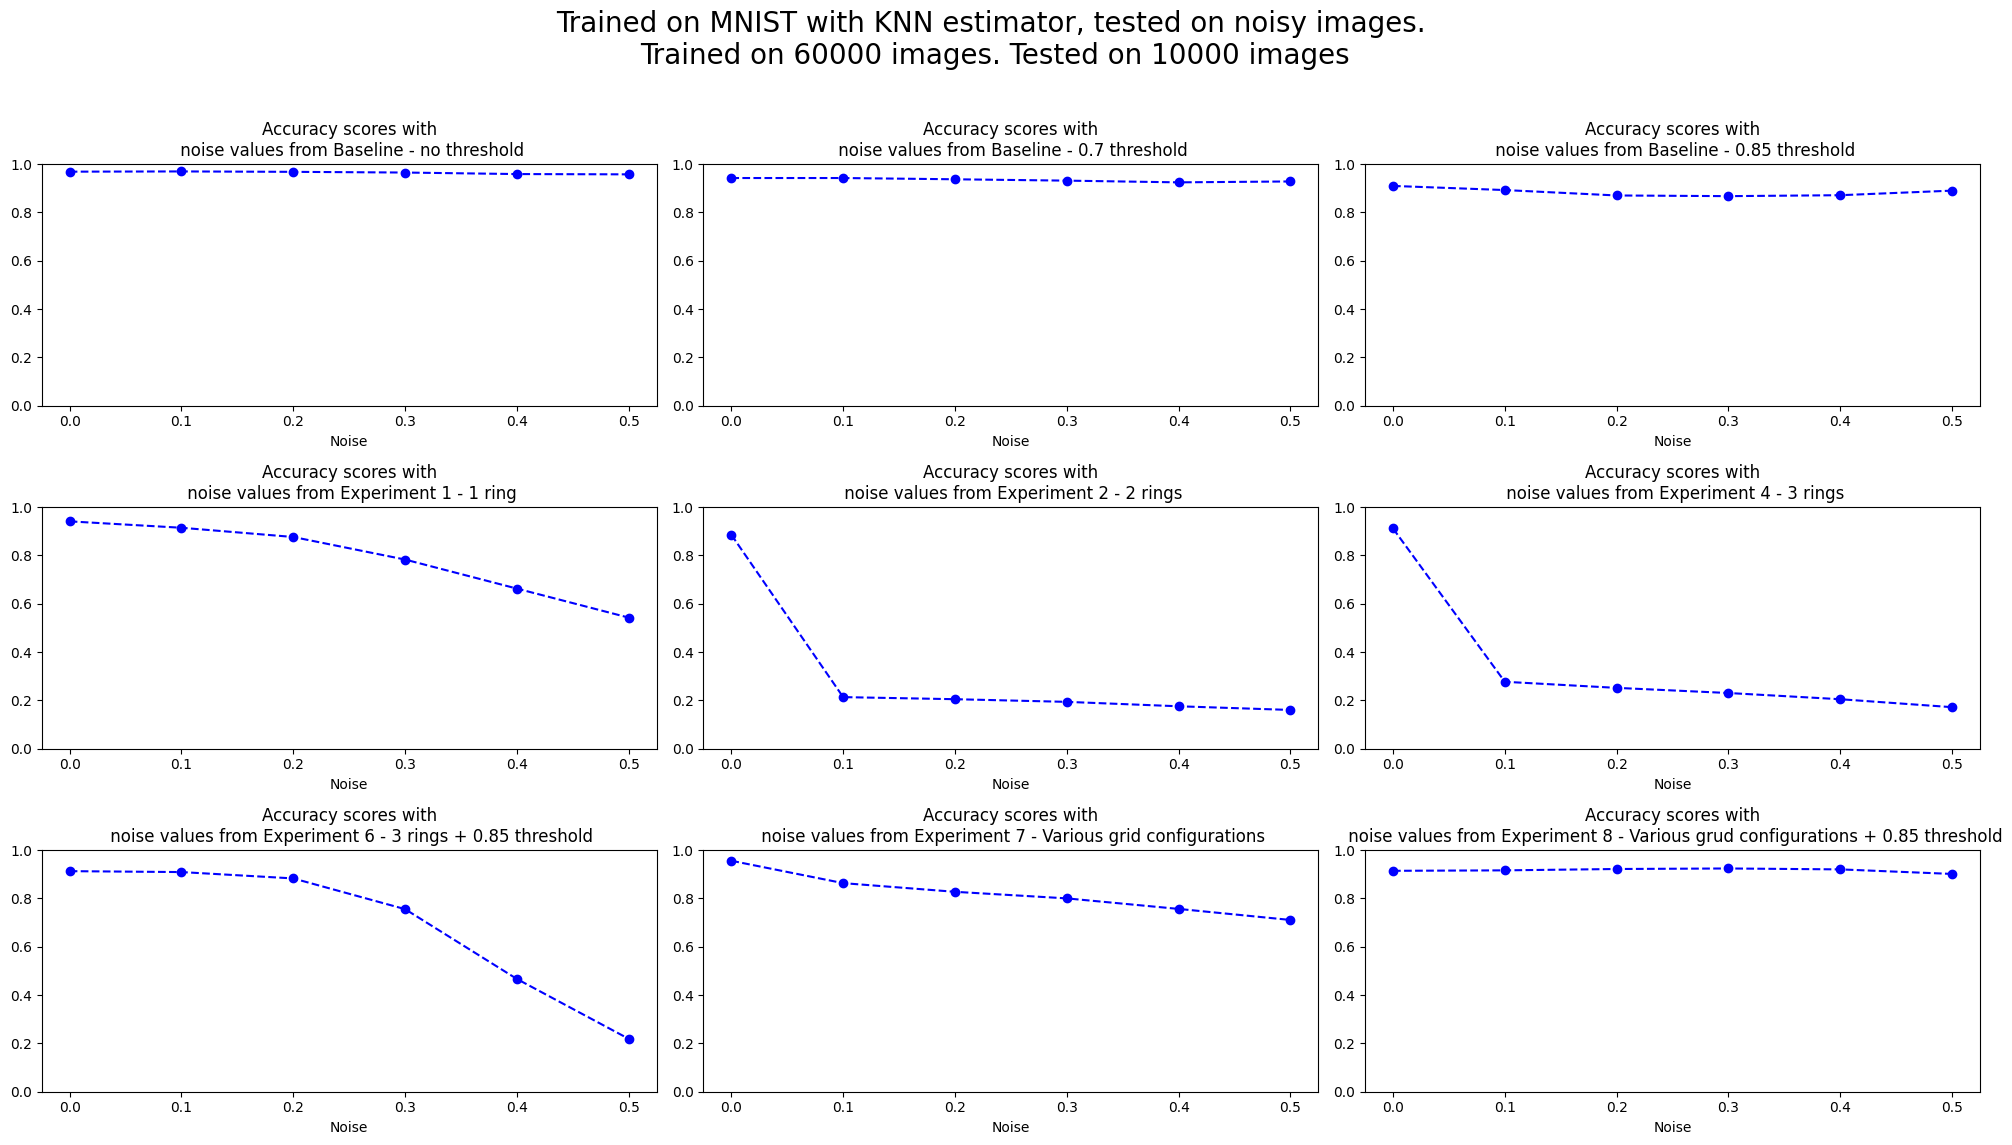

In [38]:
fig, ax = plt.subplots(3, 3, figsize=(20, 12))
for i in range(9):
    k, j = i // 3, i % 3
    ax[k][j].plot([str(t) for t in noises], scores_noisy_knn[i], linestyle='--', marker='o', color='b', label='Accuracy score')
    ax[k][j].set_title(f"Accuracy scores with\n noise values from {experiments[i]}")
    ax[k][j].set_ylim([.0, 1.])
    ax[k][j].set_xlabel("Noise") 
fig.tight_layout(rect=(0., 0.03, 1., 0.9))
fig.suptitle(f"Trained on MNIST with KNN estimator, tested on noisy images. \nTrained on {data_train.shape[0]} images. Tested on {data_test.shape[0]} images",
             fontsize=20)

### Testing with CNN - Baseline

In [70]:
cnn_scores_noise = []

In [71]:
from tensorflow import keras
from tensorflow.keras import layers

2024-05-14 03:01:11.659424: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 03:01:11.662427: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 03:01:11.703672: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 03:01:12.488645: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [72]:
mnist_train_pixelshape = [np.expand_dims(data, -1) for data in data_train]
mnist_test_pixelshape = [np.expand_dims(data, -1) for data in data_test]

input_shape = mnist_train_pixelshape[0].shape[-3:]
classes = np.unique(train_labels).shape[0]
train_labels_binary = keras.utils.to_categorical(train_labels, classes)
test_labels_binary = keras.utils.to_categorical(test_labels, classes)

In [73]:
def make_model_baseline(input_shape, num_classes):
    return keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

cnn_noises = [.0, .1, .2, .3, .4, .5]

def add_noise(std, img, shape):
    noi = np.random.normal(.0, std, size=shape)
    return img + noi[..., np.newaxis]


def score_cnn(clfs, X_train, y_train, X_test, y_test):
    scores = []
    batch_size = 128
    epochs = 15
    X_tr = np.array(X_train)

    for i, clf in enumerate(clfs):
        X_te = np.array([add_noise(cnn_noises[i], img, (27, 27)) for img in X_test])
        clf.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        clf.fit(X_tr, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)
        scores.append(clf.evaluate(X_te, y_test, verbose=0)[1])
    return scores

In [74]:
clfs_bl_cnn = [make_model_baseline(input_shape=input_shape, num_classes=classes) for _ in range(len(cnn_noises))]
cnn_scores_noise.append(score_cnn(clfs_bl_cnn, mnist_train_pixelshape, train_labels_binary, mnist_test_pixelshape, test_labels_binary))

Text(0.5, 1.0, 'CNN accuracy scores with noise values from baseline, LR')

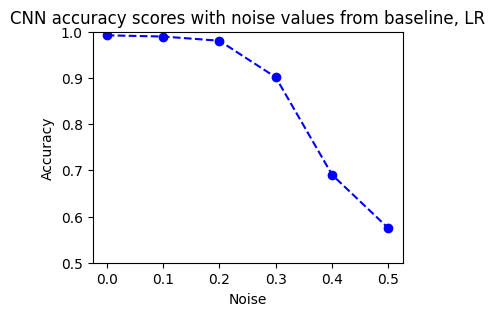

In [75]:
plt.plot([str(t) for t in cnn_noises], cnn_scores_noise[0], linestyle='--', marker='o', color='b', label='Accuracy score')
plt.ylim([.5, 1.])
plt.ylabel("Accuracy")
plt.xlabel("Noise")
plt.title("CNN accuracy scores with noise values from baseline, LR")


## Another type of noise: image blackouts

In [54]:
def black_out_section(image, size):
    offset = 28 - size
    start_row = np.random.randint(3, offset-3)
    start_col = np.random.randint(3, offset-3)
    image_copy = image.copy()
    image_copy[start_row:start_row+size, start_col:start_col+size] = 0
    return image_copy

blackout_sizes = np.arange(0, 18, 3)
blackout_tests = [np.array([black_out_section(img, size) for img in data_test]) for size in blackout_sizes]

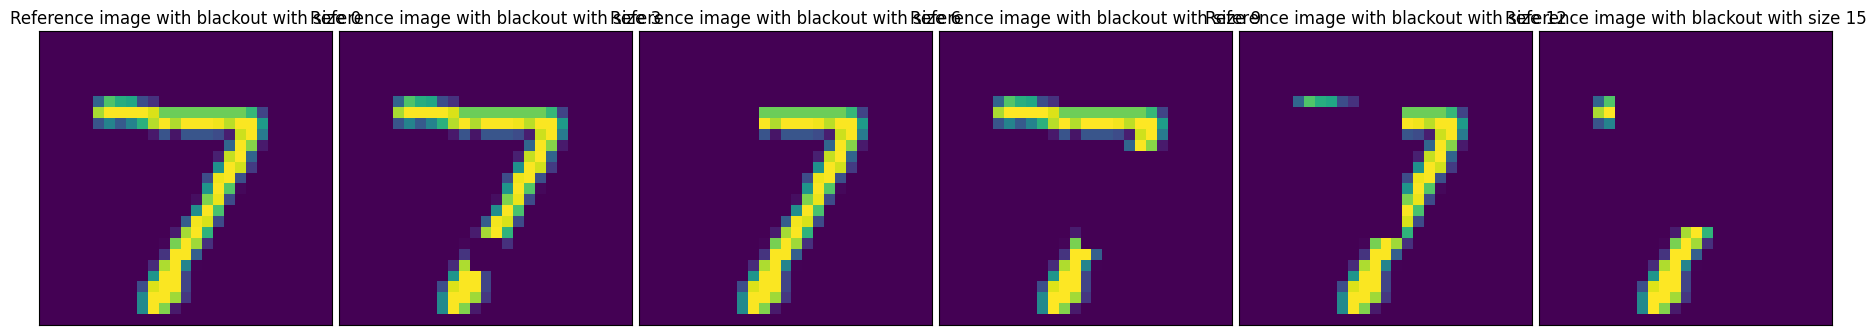

In [55]:
fig, ax = plt.subplots(1, len(blackout_sizes), figsize=(18, 3))
for i in range(len(blackout_sizes)): 
    ax[i].imshow(blackout_tests[i][0])
    ax[i].set_xticks(())
    ax[i].set_yticks(())
    ax[i].set_title(f"Reference image with blackout with size {blackout_sizes[i]}")
plt.tight_layout(pad=0.0)

### LR

In [56]:
scores_blackout_lr = []

### Baseline - LR - No thresholding

In [57]:
blackout_test_flattened = [data.reshape(-1, 27*27) for data in blackout_tests]

In [58]:
clfs_bl_lr = [LogisticRegression(fit_intercept=True,
                                 multi_class='multinomial',
                                 penalty='l2',
                                 solver='saga',
                                 max_iter=1000,
                                 n_jobs=8,
                                 tol=lr_best_tols["baseline"]) for _ in range(len(blackout_sizes))]

scores_blackout_baseline_lr = score_clfs_noisy(clfs_bl_lr, train_flattened, train_labels, blackout_test_flattened, test_labels)
scores_blackout_lr.append(scores_blackout_baseline_lr)
scores_blackout_baseline_lr

[0.9258, 0.9165, 0.8125, 0.576, 0.3445, 0.2718]

In [81]:
scores_blackout_lr.append([0.9261, 0.9161, 0.8141, 0.5696, 0.3442, 0.2731])

### Baseline - LR - 0.7 threshold

In [59]:
clfs_bl_lr_thr1 = [LogisticRegression(fit_intercept=True,
                                 multi_class='multinomial',
                                 penalty='l2',
                                 solver='saga',
                                 max_iter=1000,
                                 n_jobs=8,
                                 tol=lr_best_tols["baseline"]) for _ in range(len(blackout_sizes))]

train_flattened_blackout_threshold1 = np.where(train_flattened > 0.7, train_flattened, 0.)
test_flattened_blackout_threshold1 = [np.where(n > 0.7, n, 0.) for n in blackout_test_flattened]

scores_blackout_baseline_lr_thr1 = score_clfs_noisy(clfs_bl_lr_thr1, 
                                                    train_flattened_blackout_threshold1, 
                                                    train_labels, 
                                                    test_flattened_blackout_threshold1, 
                                                    test_labels)

scores_blackout_lr.append(scores_blackout_baseline_lr_thr1)
scores_blackout_baseline_lr_thr1

[0.9159, 0.9057, 0.8273, 0.628, 0.3971, 0.3103]

In [82]:
scores_blackout_lr.append([0.916, 0.9056, 0.8251, 0.6239, 0.4003, 0.312])

### Baseline - LR - 0.85 threshold

In [60]:
clfs_bl_lr_thr2 = [LogisticRegression(fit_intercept=True,
                                 multi_class='multinomial',
                                 penalty='l2',
                                 solver='saga',
                                 max_iter=1000,
                                 n_jobs=8,
                                 tol=lr_best_tols["baseline"]) for _ in range(len(blackout_sizes))]

train_flattened_blackout_threshold2 = np.where(train_flattened > 0.85, train_flattened, 0.)
test_flattened_blackout_threshold2 = [np.where(n > 0.85, n, 0.) for n in blackout_test_flattened]

scores_blackout_baseline_lr_thr2 = score_clfs_noisy(clfs_bl_lr_thr2, 
                                                    train_flattened_blackout_threshold2, 
                                                    train_labels, 
                                                    test_flattened_blackout_threshold2, 
                                                    test_labels)

scores_blackout_lr.append(scores_blackout_baseline_lr_thr2)
scores_blackout_baseline_lr_thr2

[0.9035, 0.8946, 0.8311, 0.6523, 0.4396, 0.3369]

In [83]:
scores_blackout_lr.append([0.9035, 0.8937, 0.827, 0.6508, 0.4357, 0.3419])

#### Experiment 1

In [61]:
exp_1_test_blackout_transformed = [experiment1(test) for test in blackout_tests]

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)


In [62]:
clfs_lr_ex1_blackout = [LogisticRegression(fit_intercept=True,
                                           multi_class='multinomial',
                                           penalty='l2',
                                           solver='saga',
                                           max_iter=1000,
                                           n_jobs=64,
                                           tol=lr_best_tols["exp1"]) for _ in range(len(blackout_sizes))]

scores_blackout_exp1_lr = score_clfs_noisy(clfs_lr_ex1_blackout, exp_1_train_transformed, train_labels, exp_1_test_blackout_transformed, test_labels)
scores_blackout_lr.append(scores_blackout_exp1_lr)
scores_blackout_exp1_lr

[0.9238, 0.9099, 0.8095, 0.5334, 0.258, 0.1155]

In [63]:
[save_coefficients("test/experiment1", t, f"blackout_test_{blackout_sizes[i]}") for i, t in enumerate(exp_1_test_blackout_transformed)]

coefficients/test/experiment1/blackout_test_0.npy saved
coefficients/test/experiment1/blackout_test_3.npy saved
coefficients/test/experiment1/blackout_test_6.npy saved
coefficients/test/experiment1/blackout_test_9.npy saved
coefficients/test/experiment1/blackout_test_12.npy saved
coefficients/test/experiment1/blackout_test_15.npy saved


[None, None, None, None, None, None]

In [84]:
scores_blackout_lr.append([0.9238, 0.9107, 0.8067, 0.5299, 0.2633, 0.1199])

#### Experiment 2

In [64]:
exp_2_test_blackout_transformed = [experiment2(test) for test in blackout_tests]

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)


In [65]:
clfs_lr_ex2_blackout = [LogisticRegression(fit_intercept=True,
                                           multi_class='multinomial',
                                           penalty='l2',
                                           solver='saga',
                                           max_iter=1000,
                                           n_jobs=8,
                                           tol=lr_best_tols["exp2"]) for _ in range(len(blackout_sizes))]

scores_blackout_exp2_lr = score_clfs_noisy(clfs_lr_ex2_blackout, exp_2_train_transformed, train_labels, exp_2_test_blackout_transformed, test_labels)
scores_blackout_lr.append(scores_blackout_exp2_lr)
scores_blackout_exp2_lr

[0.9461, 0.9375, 0.8757, 0.6589, 0.3556, 0.1693]

In [85]:
scores_blackout_lr.append([0.9461, 0.936, 0.8743, 0.66, 0.3572, 0.1717])

In [66]:
[save_coefficients("test/experiment2", t, f"blackout_test_{blackout_sizes[i]}") for i, t in enumerate(exp_2_test_blackout_transformed)]

coefficients/test/experiment2/blackout_test_0.npy saved
coefficients/test/experiment2/blackout_test_3.npy saved
coefficients/test/experiment2/blackout_test_6.npy saved
coefficients/test/experiment2/blackout_test_9.npy saved
coefficients/test/experiment2/blackout_test_12.npy saved
coefficients/test/experiment2/blackout_test_15.npy saved


[None, None, None, None, None, None]

#### Experiment 4

In [67]:
exp_4_test_blackout_transformed = [experiment4(test) for test in blackout_tests]

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) 

In [68]:
clfs_lr_ex4_blackout = [LogisticRegression(fit_intercept=True,
                                           multi_class='multinomial',
                                           penalty='l2',
                                           solver='saga',
                                           max_iter=1000,
                                           n_jobs=8,
                                           tol=lr_best_tols["exp4"]) for _ in range(len(blackout_sizes))]

scores_blackout_exp4_lr = score_clfs_noisy(clfs_lr_ex4_blackout, exp_4_train_transformed, train_labels, exp_4_test_blackout_transformed, test_labels)
scores_blackout_lr.append(scores_blackout_exp4_lr)
scores_blackout_exp4_lr

[0.9713, 0.9639, 0.9091, 0.6793, 0.3674, 0.1534]

In [86]:
scores_blackout_lr.append([0.971, 0.9652, 0.9129, 0.6957, 0.3808, 0.1875])

In [69]:
[save_coefficients("test/experiment4", t, f"blackout_test_{blackout_sizes[i]}") for i, t in enumerate(exp_4_test_blackout_transformed)]

coefficients/test/experiment4/blackout_test_0.npy saved
coefficients/test/experiment4/blackout_test_3.npy saved
coefficients/test/experiment4/blackout_test_6.npy saved
coefficients/test/experiment4/blackout_test_9.npy saved
coefficients/test/experiment4/blackout_test_12.npy saved
coefficients/test/experiment4/blackout_test_15.npy saved


[None, None, None, None, None, None]

#### Experiment 6

In [71]:
exp_6_test_blackout_transformed = [experiment6(test, threshold=0.85) for test in blackout_tests]

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) 

In [72]:
clfs_lr_ex6_blackout = [LogisticRegression(fit_intercept=True,
                                           multi_class='multinomial',
                                           penalty='l2',
                                           solver='saga',
                                           max_iter=1000,
                                           n_jobs=8,
                                           tol=lr_best_tols["exp6"]) for _ in range(len(blackout_sizes))]

scores_blackout_exp6_lr = score_clfs_noisy(clfs_lr_ex6_blackout, exp_6_train_transformed, train_labels, exp_6_test_blackout_transformed, test_labels)
scores_blackout_lr.append(scores_blackout_exp6_lr)
scores_blackout_exp6_lr

[0.9306, 0.9187, 0.8544, 0.7069, 0.4851, 0.2851]

In [87]:
scores_blackout_lr.append([0.9326, 0.9189, 0.8607, 0.7351, 0.5541, 0.3414])

In [73]:
[save_coefficients("test/experiment6", t, f"blackout_test_{blackout_sizes[i]}") for i, t in enumerate(exp_6_test_blackout_transformed)]

coefficients/test/experiment6/blackout_test_0.npy saved
coefficients/test/experiment6/blackout_test_3.npy saved
coefficients/test/experiment6/blackout_test_6.npy saved
coefficients/test/experiment6/blackout_test_9.npy saved
coefficients/test/experiment6/blackout_test_12.npy saved
coefficients/test/experiment6/blackout_test_15.npy saved


[None, None, None, None, None, None]

#### Experiment 7

In [74]:
exp_7_test_blackout_transformed = [experiment7(test, grids=[(3, 3), (2, 5), (1, 7)]) for test in blackout_tests]

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) 

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) 

In [75]:
clfs_lr_ex7_blackout = [LogisticRegression(fit_intercept=True,
                                           multi_class='multinomial',
                                           penalty='l2',
                                           solver='saga',
                                           max_iter=1000,
                                           n_jobs=8,
                                           tol=.001) for _ in range(len(blackout_sizes))]

scores_blackout_exp7_lr = score_clfs_noisy(clfs_lr_ex7_blackout, exp_7_train_transformed, train_labels, exp_7_test_blackout_transformed, test_labels)
scores_blackout_lr.append(scores_blackout_exp7_lr)
scores_blackout_exp7_lr

[0.9791, 0.9731, 0.8943, 0.6, 0.3129, 0.1527]

In [88]:
scores_blackout_lr.append([0.979, 0.9739, 0.8855, 0.5879, 0.3033, 0.1542])

In [76]:
[save_coefficients("test/experiment7", t, f"blackout_test_{blackout_sizes[i]}") for i, t in enumerate(exp_7_test_blackout_transformed)]

coefficients/test/experiment7/blackout_test_0.npy saved
coefficients/test/experiment7/blackout_test_3.npy saved
coefficients/test/experiment7/blackout_test_6.npy saved
coefficients/test/experiment7/blackout_test_9.npy saved
coefficients/test/experiment7/blackout_test_12.npy saved
coefficients/test/experiment7/blackout_test_15.npy saved


[None, None, None, None, None, None]

#### Experiment 8

In [77]:
exp_8_test_blackout_transformed = [experiment8(test, threshold=0.85) for test in blackout_tests]

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) 

In [78]:
clfs_lr_ex8_blackout = [LogisticRegression(fit_intercept=True,
                                           multi_class='multinomial',
                                           penalty='l2',
                                           solver='saga',
                                           max_iter=1000,
                                           n_jobs=8,
                                           tol=lr_best_tols["exp8"]) for _ in range(len(blackout_sizes))]

scores_blackout_exp8_lr = score_clfs_noisy(clfs_lr_ex8_blackout, exp_8_train_transformed, train_labels, exp_8_test_blackout_transformed, test_labels)
scores_blackout_lr.append(scores_blackout_exp8_lr)
scores_blackout_exp8_lr

[0.9579, 0.9469, 0.87, 0.7156, 0.5009, 0.2984]

In [89]:
scores_blackout_lr.append([0.9809, 0.9661, 0.9028, 0.6612, 0.4621, 0.1712])

In [79]:
[save_coefficients("test/experiment8", t, f"blackout_test_{blackout_sizes[i]}") for i, t in enumerate(exp_8_test_blackout_transformed)]

coefficients/test/experiment8/blackout_test_0.npy saved
coefficients/test/experiment8/blackout_test_3.npy saved
coefficients/test/experiment8/blackout_test_6.npy saved
coefficients/test/experiment8/blackout_test_9.npy saved
coefficients/test/experiment8/blackout_test_12.npy saved
coefficients/test/experiment8/blackout_test_15.npy saved


[None, None, None, None, None, None]

### Results - Blackout - LR

Text(0.5, 0.98, 'Trained on MNIST with LR estimator, tested on images with blackouts. \nTrained on 60000 images. Tested on 10000 images')

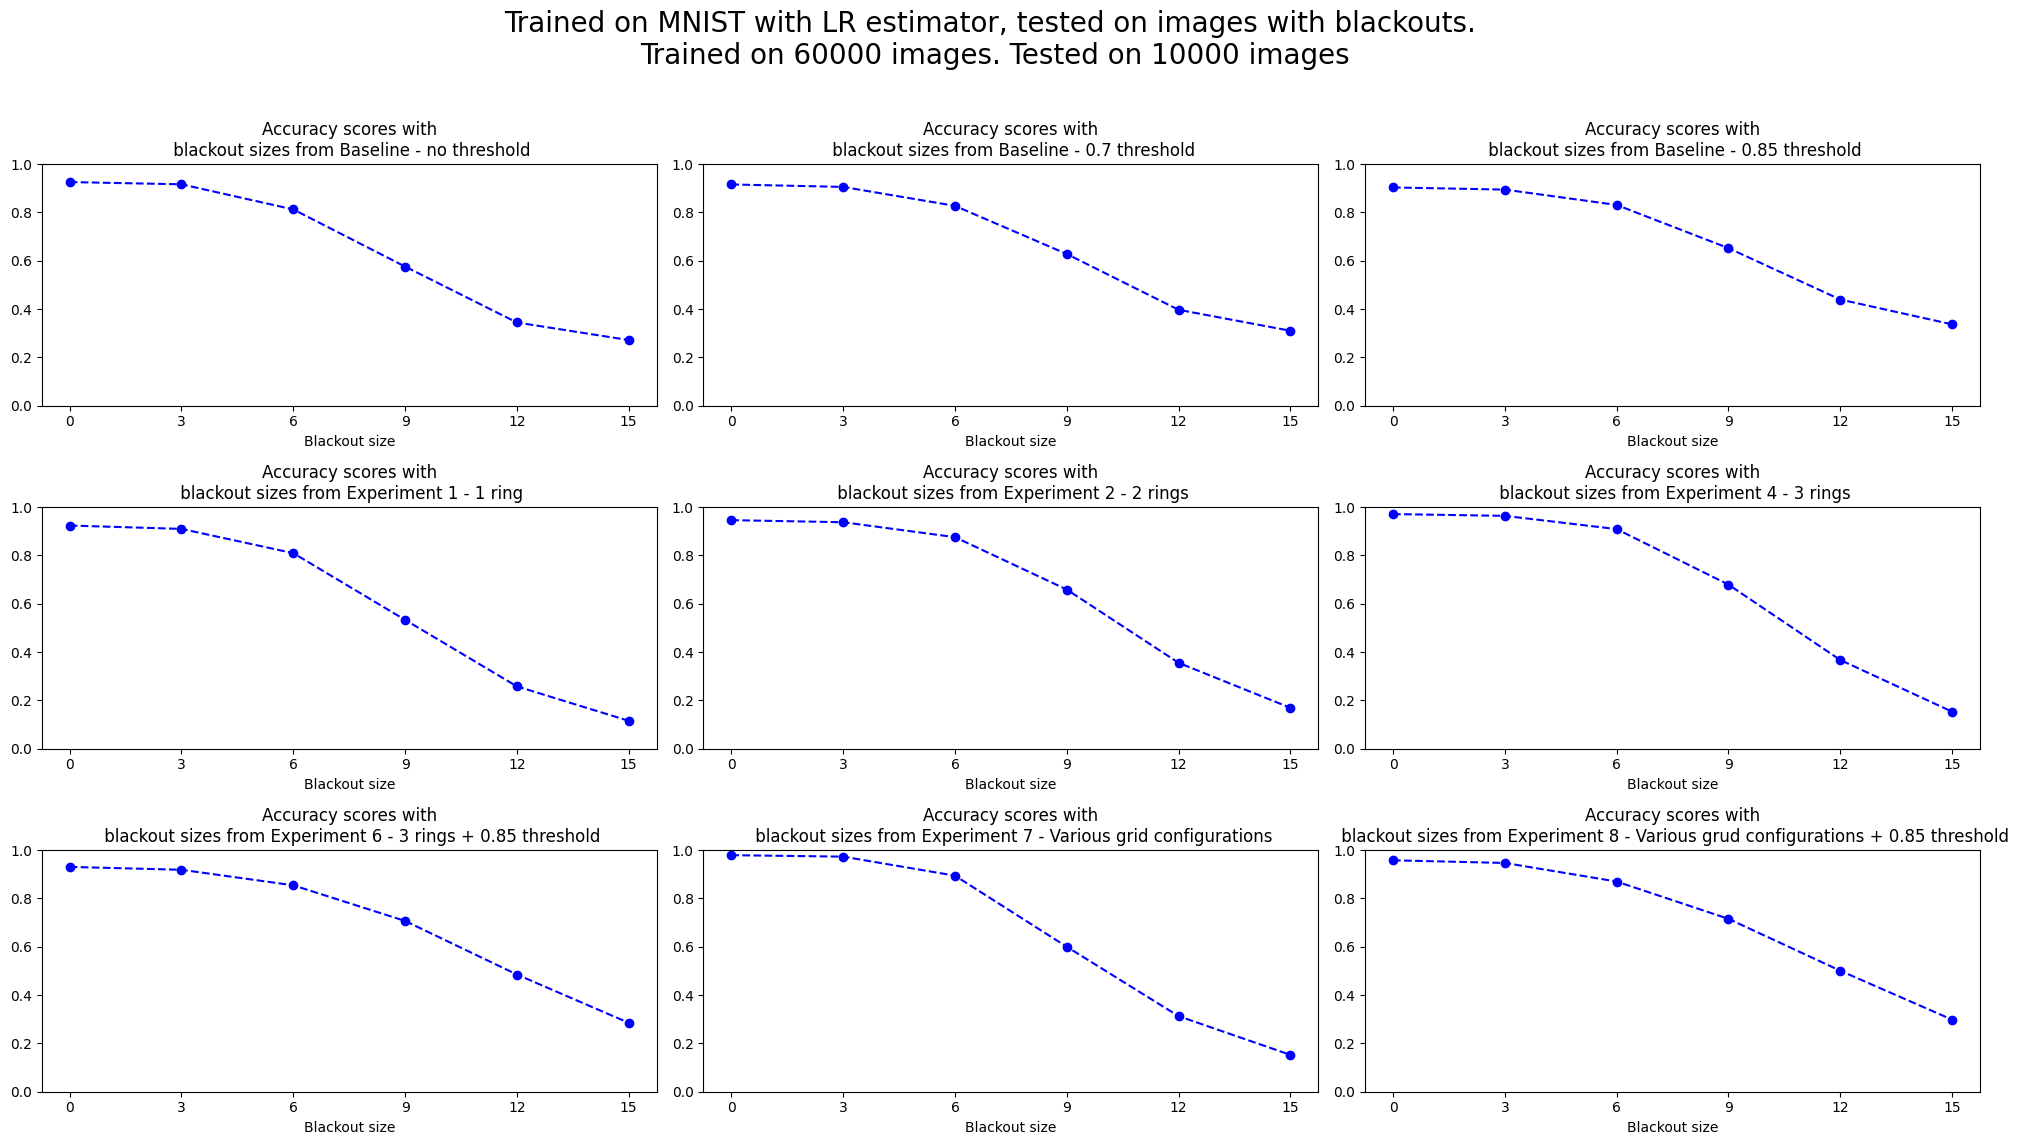

In [80]:
fig, ax = plt.subplots(3, 3, figsize=(20, 12))
for i in range(9):
    k, j = i // 3, i % 3
    ax[k][j].plot([str(t) for t in blackout_sizes], scores_blackout_lr[i], linestyle='--', marker='o', color='b', label='Accuracy score')
    ax[k][j].set_title(f"Accuracy scores with\n blackout sizes from {experiments[i]}")
    ax[k][j].set_ylim([.0, 1.])
    ax[k][j].set_xlabel("Blackout size") 
fig.tight_layout(rect=(0., 0.03, 1., 0.9))
fig.suptitle(f"Trained on MNIST with LR estimator, tested on images with blackouts. \nTrained on {data_train.shape[0]} images. Tested on {data_test.shape[0]} images",
             fontsize=20)

### SVM

In [81]:
scores_blackout_svm = []

#### Baseline - SVM - No thresholding

In [82]:
clfs_svm_blackout_bl = [SVC(kernel='rbf', C=svm_best_Cs["baseline"], gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_baseline_svm = score_clfs_noisy(clfs_svm_blackout_bl, train_flattened, train_labels, blackout_test_flattened, test_labels)
scores_blackout_svm.append(scores_blackout_baseline_svm)
scores_blackout_baseline_svm

[0.9624, 0.9568, 0.8598, 0.6278, 0.404, 0.2706]

In [117]:
scores_blackout_svm.append([0.9811, 0.9572, 0.8588, 0.6328, 0.4091, 0.278])

#### Baseline - SVM - 0.7 threshold

In [83]:
clfs_svm_blackout_bl_thr1 = [SVC(kernel='rbf', C=svm_best_Cs["baseline"], gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_baseline_svm_thr1 = score_clfs_noisy(clfs_svm_blackout_bl_thr1,
                                                    train_flattened_blackout_threshold1, 
                                                    train_labels, 
                                                    test_flattened_blackout_threshold1, 
                                                    test_labels)

scores_blackout_svm.append(scores_blackout_baseline_svm_thr1)
scores_blackout_baseline_svm_thr1

[0.9503, 0.9442, 0.8621, 0.6581, 0.4282, 0.3039]

In [118]:
scores_blackout_svm.append([0.9881, 0.9764, 0.8826, 0.6492, 0.4039, 0.3302])

#### Baseline - SVM - 0.85 threshold

In [84]:
clfs_svm_blackout_bl_thr2 = [SVC(kernel='rbf', C=svm_best_Cs["baseline"], gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_baseline_svm_thr2 = score_clfs_noisy(clfs_svm_blackout_bl_thr2,
                                                    train_flattened_blackout_threshold2, 
                                                    train_labels, 
                                                    test_flattened_blackout_threshold2, 
                                                    test_labels)

scores_blackout_svm.append(scores_blackout_baseline_svm_thr2)
scores_blackout_baseline_svm_thr2

[0.9342, 0.9286, 0.859, 0.6723, 0.4504, 0.321]

In [119]:
scores_blackout_svm.append([0.9791, 0.9721, 0.9001, 0.6676, 0.4955, 0.3571])

#### Experiment 1 - SVM

In [85]:
clfs_svm_exp1_blackout = [SVC(kernel='rbf', C=svm_best_Cs["exp1"], gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_exp1_svm = score_clfs_noisy(clfs_svm_exp1_blackout, exp_1_train_transformed, train_labels, exp_1_test_blackout_transformed, test_labels)
scores_blackout_svm.append(scores_blackout_exp1_svm)
scores_blackout_exp1_svm

[0.9534, 0.9392, 0.8271, 0.5587, 0.2956, 0.154]

In [120]:
scores_blackout_svm.append([0.9534, 0.9387, 0.8283, 0.5565, 0.2899, 0.1514])

#### Experiment 2 - SVM

In [86]:
clfs_svm_exp2_blackout = [SVC(kernel='rbf', C=svm_best_Cs["exp2"], gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_exp2_svm = score_clfs_noisy(clfs_svm_exp2_blackout, exp_2_train_transformed, train_labels, exp_2_test_blackout_transformed, test_labels)
scores_blackout_svm.append(scores_blackout_exp2_svm)
scores_blackout_exp2_svm

[0.9741, 0.9646, 0.8888, 0.6702, 0.3878, 0.2165]

In [121]:
scores_blackout_svm.append([0.9741, 0.9646, 0.8884, 0.6663, 0.3831, 0.2123])

#### Experiment 4 - SVM

In [87]:
clfs_svm_exp4_blackout = [SVC(kernel='rbf', C=svm_best_Cs["exp4"], gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_exp4_svm = score_clfs_noisy(clfs_svm_exp4_blackout, exp_4_train_transformed, train_labels, exp_4_test_blackout_transformed, test_labels)
scores_blackout_svm.append(scores_blackout_exp4_svm)
scores_blackout_exp4_svm

[0.9841, 0.978, 0.9081, 0.671, 0.3901, 0.1639]

In [122]:
scores_blackout_svm.append([0.9843, 0.9773, 0.9052, 0.6593, 0.3596, 0.1967])

#### Experiment 6 - SVM

In [88]:
clfs_svm_exp6_blackout = [SVC(kernel='rbf', C=svm_best_Cs["exp6"], gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_exp6_svm = score_clfs_noisy(clfs_svm_exp6_blackout, exp_6_train_transformed, train_labels, exp_6_test_blackout_transformed, test_labels)
scores_blackout_svm.append(scores_blackout_exp6_svm)
scores_blackout_exp6_svm

[0.9477, 0.9356, 0.8695, 0.7373, 0.546, 0.3287]

In [123]:
scores_blackout_svm.append([0.9497, 0.9367, 0.8797, 0.7448, 0.5718, 0.3688])

#### Experiment 7 - SVM

In [89]:
clfs_svm_exp7_blackout = [SVC(kernel='rbf', C=500., gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_exp7_svm = score_clfs_noisy(clfs_svm_exp7_blackout, exp_7_train_transformed, train_labels, exp_7_test_blackout_transformed, test_labels)
scores_blackout_svm.append(scores_blackout_exp7_svm)
scores_blackout_exp7_svm

[0.9876, 0.9817, 0.8774, 0.5769, 0.3124, 0.209]

In [124]:
scores_blackout_svm.append([0.9876, 0.9813, 0.8763, 0.574, 0.3088, 0.2125])

#### Experiment 8 - SVM

In [90]:
clfs_svm_exp8_blackout = [SVC(kernel='rbf', C=svm_best_Cs["exp8"], gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_exp8_svm = score_clfs_noisy(clfs_svm_exp8_blackout, exp_8_train_transformed, train_labels, exp_8_test_blackout_transformed, test_labels)
scores_blackout_svm.append(scores_blackout_exp8_svm)
scores_blackout_exp8_svm

[0.9726, 0.9616, 0.8821, 0.7219, 0.5177, 0.2921]

In [125]:
scores_blackout_svm.append([0.9866, 0.9613, 0.8863, 0.7525, 0.5621, 0.3087])

### Results - SVM

Text(0.5, 0.98, 'Trained on MNIST with SVM estimator, tested images with blackouts. \nTrained on 60000 images. Tested on 10000 images')

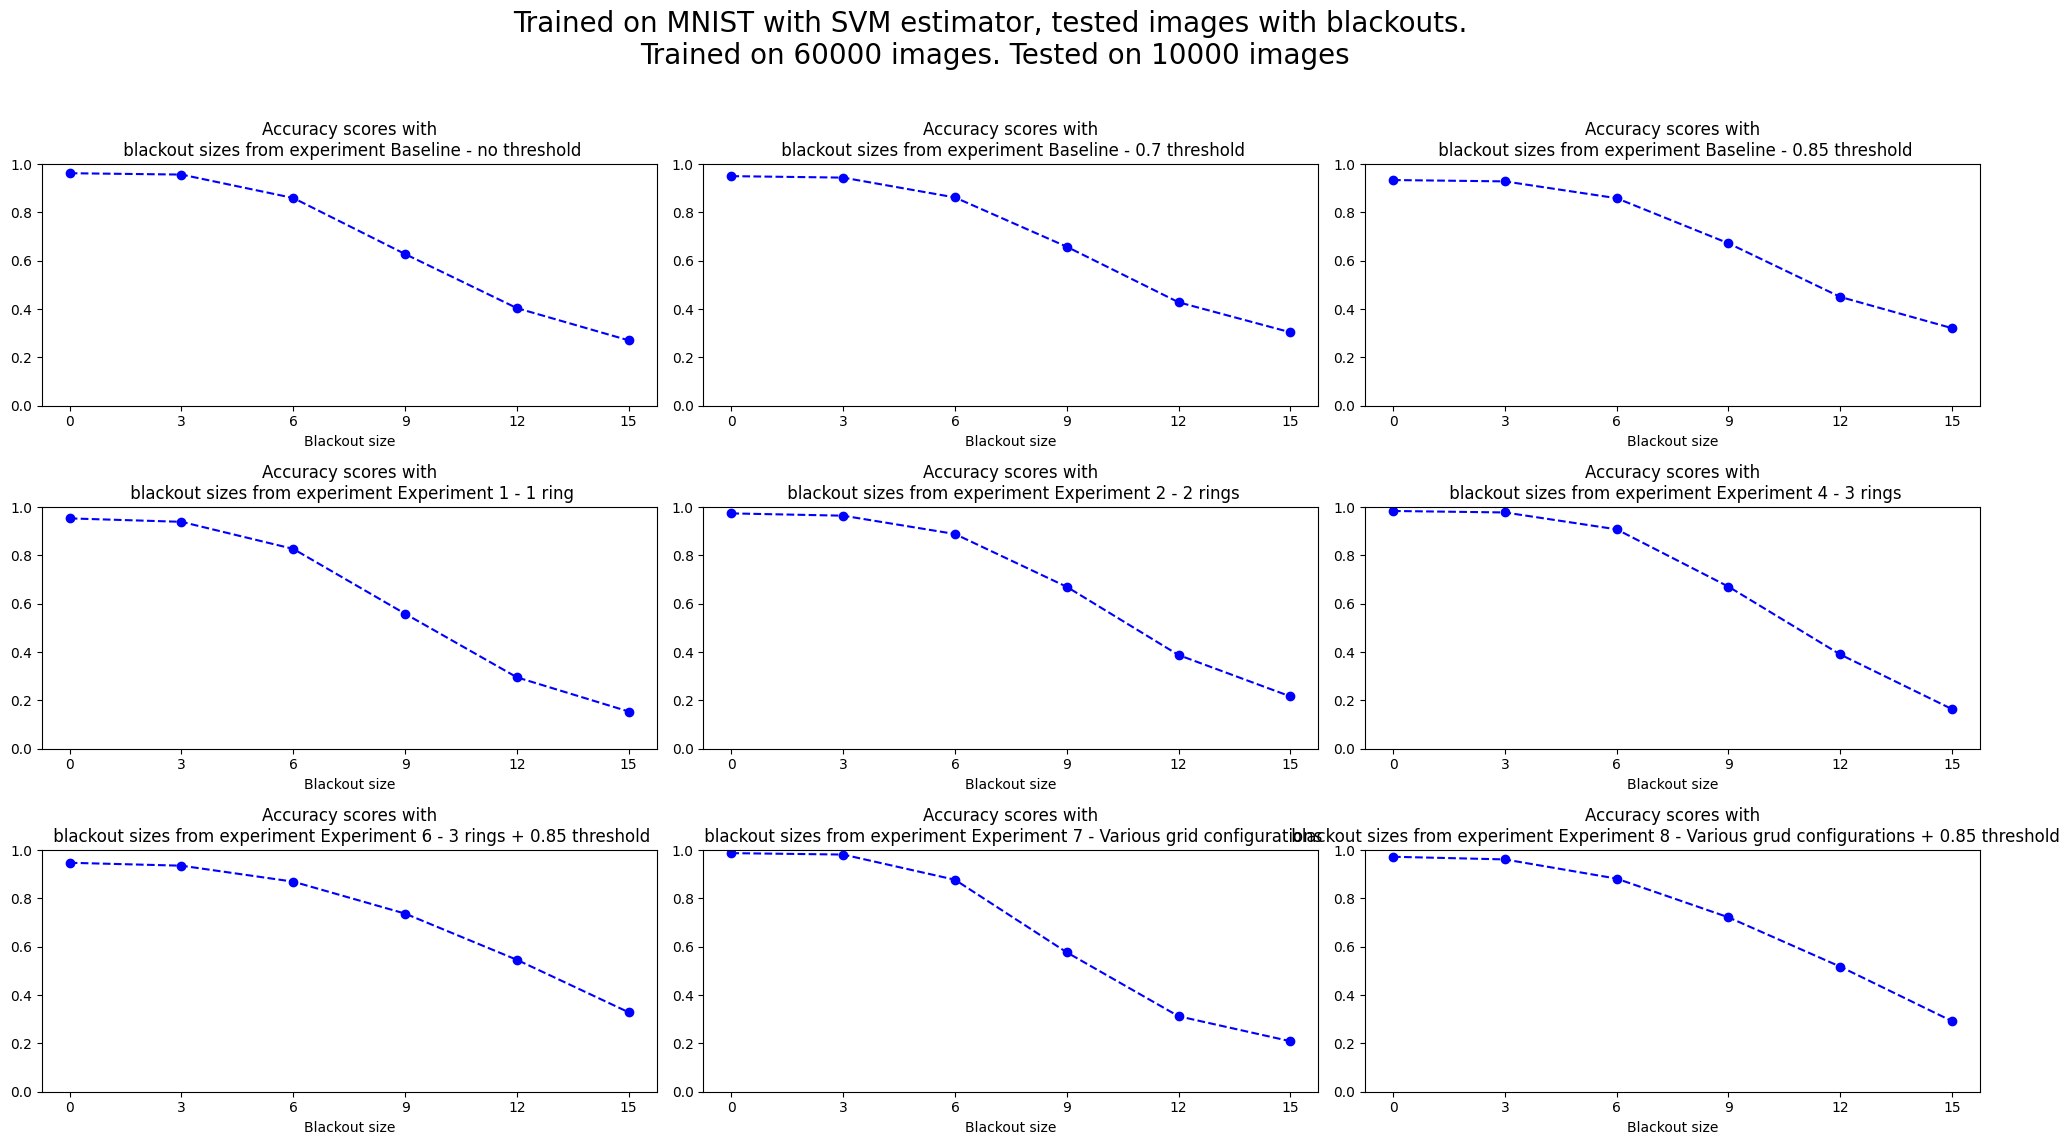

In [91]:
fig, ax = plt.subplots(3, 3, figsize=(20, 12))
for i in range(9):
    k, j = i // 3, i % 3
    ax[k][j].plot([str(t) for t in blackout_sizes], scores_blackout_svm[i], linestyle='--', marker='o', color='b', label='Accuracy score')
    ax[k][j].set_title(f"Accuracy scores with\n blackout sizes from experiment {experiments[i]}")
    ax[k][j].set_ylim([.0, 1.])
    ax[k][j].set_xlabel("Blackout size") 
fig.tight_layout(rect=(0., 0.03, 1., 0.9))
fig.suptitle(f"Trained on MNIST with SVM estimator, tested images with blackouts. \nTrained on {data_train.shape[0]} images. Tested on {data_test.shape[0]} images",
             fontsize=20)
#fig.delaxes(ax[1,3])

### KNN

In [92]:
scores_blackout_knn = []

#### Baseline - KNN - No thresholding

In [93]:
clfs_knn_blackout_bl = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
baseline_knn_scores_blackout = score_clfs_noisy(clfs_knn_blackout_bl, train_flattened, train_labels, blackout_test_flattened, test_labels)
scores_blackout_knn.append(baseline_knn_scores_blackout)
baseline_knn_scores_blackout

[0.9688, 0.9663, 0.9325, 0.8314, 0.6433, 0.3131]

#### Baseline - KNN - 0.7 threshold

In [94]:
clfs_knn_blackout_bl_thr1 = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
baseline_knn_scores_thr1 = score_clfs_noisy(clfs_knn_blackout_bl_thr1, 
                                       train_flattened_blackout_threshold1, 
                                       train_labels, 
                                       test_flattened_blackout_threshold1, 
                                       test_labels)

scores_blackout_knn.append(baseline_knn_scores_thr1)
baseline_knn_scores_thr1

[0.9425, 0.939, 0.8961, 0.7851, 0.5557, 0.213]

#### Baseline - KNN - 0.85 threshold

In [95]:
clfs_knn_blackout_bl_thr2 = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]

baseline_knn_scores_thr2 = score_clfs_noisy(clfs_knn_blackout_bl_thr2, 
                                       train_flattened_blackout_threshold2, 
                                       train_labels, 
                                       test_flattened_blackout_threshold2, 
                                       test_labels)

scores_blackout_knn.append(baseline_knn_scores_thr2)
baseline_knn_scores_thr2

[0.9098, 0.9001, 0.8506, 0.7155, 0.4435, 0.1623]

#### Experiment 1 - KNN

In [96]:
clfs_knn_exp1_blackout = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(blackout_sizes))]
scores_blackout_exp1_knn = score_clfs_noisy(clfs_knn_exp1_blackout, exp_1_train_transformed, train_labels, exp_1_test_blackout_transformed, test_labels)
scores_blackout_knn.append(scores_blackout_exp1_knn)
scores_blackout_exp1_knn

[0.9411, 0.9264, 0.8001, 0.4898, 0.2727, 0.1861]

#### Experiment 2 - KNN

In [97]:
clfs_knn_exp2_blackout = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(blackout_sizes))]
scores_blackout_exp2_knn = score_clfs_noisy(clfs_knn_exp2_blackout, exp_2_train_transformed, train_labels, exp_2_test_blackout_transformed, test_labels)
scores_blackout_knn.append(scores_blackout_exp2_knn)
scores_blackout_exp2_knn

[0.8856, 0.884, 0.8509, 0.722, 0.5336, 0.3499]

#### Experiment 4 - KNN

In [98]:
clfs_knn_exp4_blackout = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(blackout_sizes))]
scores_blackout_exp4_knn = score_clfs_noisy(clfs_knn_exp4_blackout, exp_4_train_transformed, train_labels, exp_4_test_blackout_transformed, test_labels)
scores_blackout_knn.append(scores_blackout_exp4_knn)
scores_blackout_exp4_knn

[0.9117, 0.9096, 0.8756, 0.7548, 0.5427, 0.3598]

#### Experiment 6 - KNN

In [99]:
clfs_knn_exp6_blackout = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(blackout_sizes))]
scores_blackout_exp6_knn = score_clfs_noisy(clfs_knn_exp6_blackout, exp_6_train_transformed, train_labels, exp_6_test_blackout_transformed, test_labels)
scores_blackout_knn.append(scores_blackout_exp6_knn)
scores_blackout_exp6_knn

[0.913, 0.9015, 0.8445, 0.7454, 0.5913, 0.3651]

#### Experiment 7 - KNN

In [100]:
clfs_knn_exp7_blackout = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(blackout_sizes))]
scores_blackout_exp7_knn = score_clfs_noisy(clfs_knn_exp7_blackout, exp_7_train_transformed, train_labels, exp_7_test_blackout_transformed, test_labels)
scores_blackout_knn.append(scores_blackout_exp7_knn)
scores_blackout_exp7_knn

[0.9577, 0.9563, 0.8512, 0.4984, 0.2822, 0.205]

#### Experiment 8 - KNN

In [101]:
clfs_knn_exp8_blackout = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(blackout_sizes))]
scores_blackout_exp8_knn = score_clfs_noisy(clfs_knn_exp8_blackout, exp_8_train_transformed, train_labels, exp_8_test_blackout_transformed, test_labels)
scores_blackout_knn.append(scores_blackout_exp8_knn)
scores_blackout_exp8_knn

[0.9553, 0.944, 0.8568, 0.6802, 0.493, 0.3193]

#### KNN - Results

Text(0.5, 0.98, 'Trained on MNIST with KNN estimator, tested images with blackouts. \nTrained on 60000 images. Tested on 10000 images')

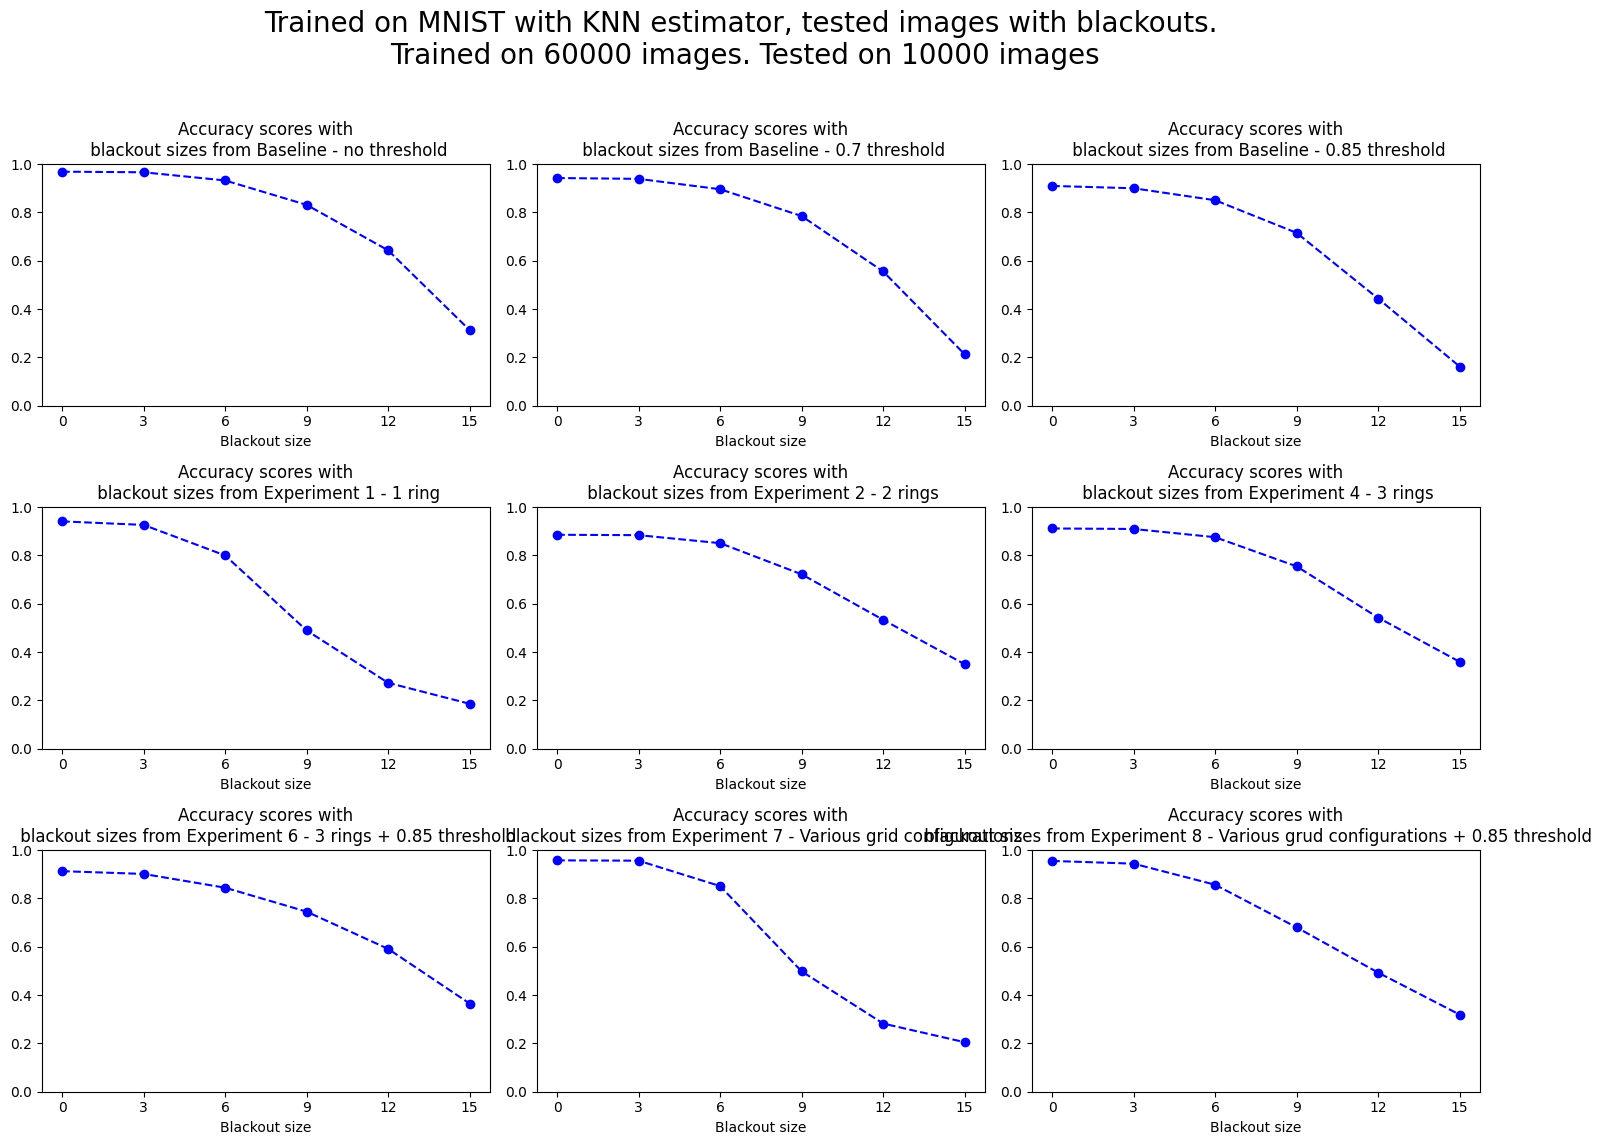

In [102]:
fig, ax = plt.subplots(3, 3, figsize=(15, 12))
for i in range(9):
    k, j = i // 3, i % 3
    ax[k][j].plot([str(t) for t in blackout_sizes], scores_blackout_knn[i], linestyle='--', marker='o', color='b', label='Accuracy score')
    ax[k][j].set_title(f"Accuracy scores with\n blackout sizes from {experiments[i]}")
    ax[k][j].set_ylim([.0, 1.])
    ax[k][j].set_xlabel("Blackout size") 
fig.tight_layout(rect=(0., 0.03, 1., 0.9))
fig.suptitle(f"Trained on MNIST with KNN estimator, tested images with blackouts. \nTrained on {data_train.shape[0]} images. Tested on {data_test.shape[0]} images",
             fontsize=20)

### Testing with CNN - Baseline

In [ ]:
cnn_blackout_scores_noise = []

In [96]:
def score_cnn_bl(clfs, X_train, y_train, X_test, y_test):
    scores = []
    batch_size = 128
    epochs = 15
    X_tr = np.array(X_train)

    for i, clf in enumerate(clfs):
        X_te = np.array([black_out_section(img, blackout_sizes[i]) for img in X_test])
        clf.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        clf.fit(X_tr, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)
        scores.append(clf.evaluate(X_te, y_test, verbose=0)[1])
    return scores

In [97]:
clfs_blackout_bl_cnn = [make_model_baseline(input_shape=input_shape, num_classes=classes) for _ in range(len(blackout_sizes))]
cnn_blackout_scores_noise.append(score_cnn_bl(clfs_blackout_bl_cnn, mnist_train_pixelshape, train_labels_binary, mnist_test_pixelshape, test_labels_binary))

Text(0.5, 1.0, 'CNN accuracy scores with blackout sizes from baseline, SVM')

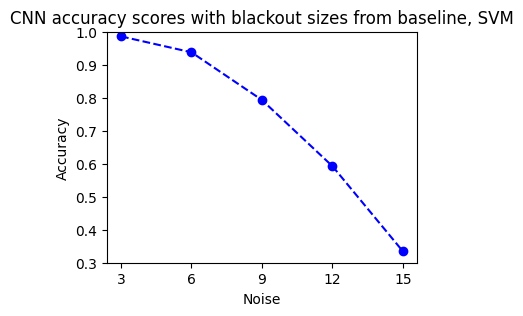

In [99]:
plt.plot([str(t) for t in blackout_sizes], cnn_blackout_scores_noise[0], linestyle='--', marker='o', color='b', label='Accuracy score')
plt.ylim([.3, 1.])
plt.ylabel("Accuracy")
plt.xlabel("Noise")
plt.title("CNN accuracy scores with blackout sizes from baseline, SVM")

#### Inverted test set

In [41]:
inverted_test = np.array([img * -1 for img in data_test])

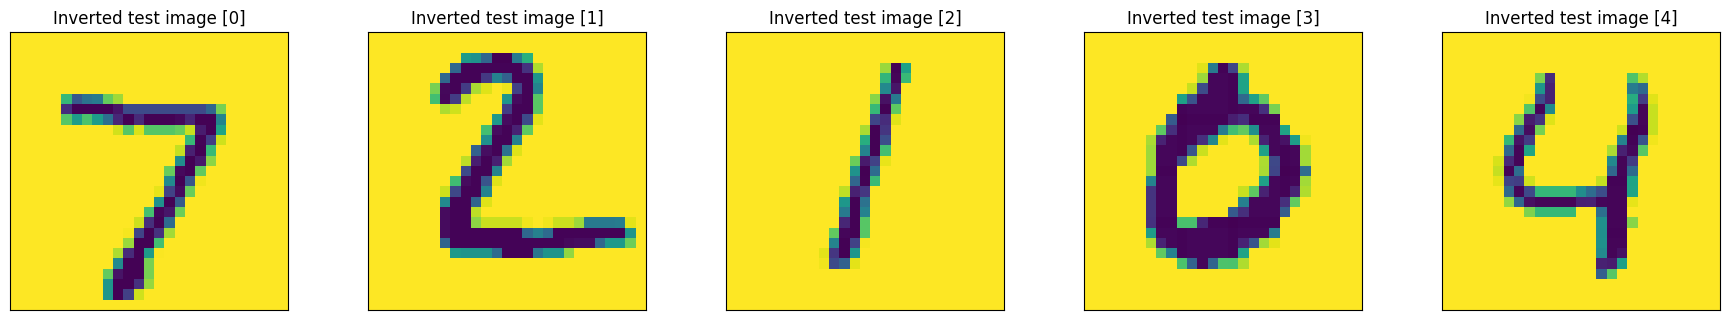

In [13]:
fig, ax = plt.subplots(1, 5, figsize=(18, 3))
for i in range(5): 
    ax[i].imshow(inverted_test[i])
    ax[i].set_xticks(())
    ax[i].set_yticks(())
    ax[i].set_title(f"Inverted test image {[i]}")
plt.tight_layout(pad=0.0)

### LR

In [47]:
inv_test_flattened = np.array([data.reshape(27*27) for data in inverted_test])
scores_inv = []

In [15]:
def score_inv_clf(clf, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    return clf.score(x_test, y_test)

In [48]:
scores_inv = [0.0, 0.0892, 0.0892, 0.9724, 0.9509, 0.9772, 0.9468]

#### Baseline - no thresholding

In [100]:
clfs_inv_bl_lr = LogisticRegression(fit_intercept=True,
                                     multi_class='multinomial',
                                     penalty='l2',
                                     solver='saga',
                                     max_iter=1000,
                                     n_jobs=64,
                                     tol=lr_best_tols["baseline"])

scores_inv_baseline_lr = score_inv_clf(clfs_inv_bl_lr, train_flattened, train_labels, inv_test_flattened, test_labels)
scores_inv.append(scores_inv_baseline_lr)
scores_inv_baseline_lr

0.0

In [34]:
train_flattened_inv_threshold1 = np.where(train_flattened > 0.7, train_flattened, 0.)
test_flattened_inv_threshold1 = np.where(inv_test_flattened > 0.7, inv_test_flattened, 0.)
train_flattened_inv_threshold2 = np.where(train_flattened > 0.85, train_flattened, 0.)
test_flattened_inv_threshold2 = np.where(inv_test_flattened > 0.85, inv_test_flattened, 0.)

#### Baseline - 0.7 threshold

In [37]:
clfs_inv_bl_lr_thr1 = LogisticRegression(fit_intercept=True,
                                          multi_class='multinomial',
                                          penalty='l2',
                                          solver='saga',
                                          max_iter=1000,
                                          n_jobs=64,
                                          tol=lr_best_tols["baseline"])

train_flattened_inv_threshold1 = np.where(train_flattened > 0.7, train_flattened, 0.)
test_flattened_inv_threshold1 = np.where(inv_test_flattened > 0.7, inv_test_flattened, 0.)

scores_inv_baseline_lr_thr1 = score_inv_clf(clfs_inv_bl_lr_thr1, 
                                            train_flattened_inv_threshold1, 
                                            train_labels, 
                                            test_flattened_inv_threshold1, 
                                            test_labels)

scores_inv.append(scores_inv_baseline_lr_thr1)
scores_inv_baseline_lr_thr1

0.0892

#### Baseline - 0.85 threshold

In [39]:
clfs_inv_bl_lr_thr2 = LogisticRegression(fit_intercept=True,
                                          multi_class='multinomial',
                                          penalty='l2',
                                          solver='saga',
                                          max_iter=1000,
                                          n_jobs=64,
                                          tol=lr_best_tols["baseline"])

train_flattened_inv_threshold2 = np.where(train_flattened > 0.85, train_flattened, 0.)
test_flattened_inv_threshold2 = np.where(inv_test_flattened > 0.85, inv_test_flattened, 0.)

scores_inv_baseline_lr_thr2 = score_inv_clf(clfs_inv_bl_lr_thr2, 
                                            train_flattened_inv_threshold2, 
                                            train_labels, 
                                            test_flattened_inv_threshold2, 
                                            test_labels)

scores_inv.append(scores_inv_baseline_lr_thr2)
scores_inv_baseline_lr_thr2

0.0892

#### Experiment 4 - LR

In [16]:
exp4_train_img_inv = experiment4_img_neg(data_train)
exp_4_test_inv_transformed = experiment4_img_neg(inverted_test)

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) 

In [17]:
save_coefficients("train", exp4_train_img_inv, "experiment_4_img_neg")
save_coefficients("test/experiment4_img_neg", exp_4_test_inv_transformed, "experiment4_inv_test")

coefficients/train/experiment_4_img_neg.npy saved
coefficients/test/experiment4_img_neg/experiment4_inv_test.npy saved


In [18]:
clfs_lr_ex4_inv = LogisticRegression(fit_intercept=True,
                                     multi_class='multinomial',
                                     penalty='l2',
                                     solver='saga',
                                     max_iter=1000,
                                     n_jobs=8,
                                     tol=lr_best_tols["exp4"]) 

scores_inv_exp4_lr = score_inv_clf(clfs_lr_ex4_inv, 
                                   exp4_train_img_inv, 
                                   train_labels, 
                                   exp_4_test_inv_transformed, 
                                   test_labels)

scores_inv.append(scores_inv_exp4_lr)
scores_inv_exp4_lr

0.9724

#### Experiment 6 - LR

In [19]:
exp6_train_img_inv = experiment6_img_neg(data_train)
exp_6_test_inv_transformed = experiment6_img_neg(inverted_test)

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) 

In [20]:
save_coefficients("train", exp6_train_img_inv, "experiment_6_img_neg")
save_coefficients("test/experiment6_img_neg", exp_6_test_inv_transformed, "experiment6_inv_test")

coefficients/train/experiment_6_img_neg.npy saved
coefficients/test/experiment6_img_neg/experiment6_inv_test.npy saved


In [21]:
clfs_lr_ex6_inv = LogisticRegression(fit_intercept=True,
                                     multi_class='multinomial',
                                     penalty='l2',
                                     solver='saga',
                                     max_iter=1000,
                                     n_jobs=8,
                                     tol=lr_best_tols["exp6"]) 

scores_inv_exp6_lr = score_inv_clf(clfs_lr_ex6_inv, 
                                   exp6_train_img_inv, 
                                   train_labels, 
                                   exp_6_test_inv_transformed, 
                                   test_labels)

scores_inv.append(scores_inv_exp6_lr)
scores_inv_exp6_lr

0.9509

#### Experiment 7 - LR

In [22]:
exp7_train_img_inv = experiment7_img_neg(data_train, grids=[(3, 3), (2, 5), (1, 7)])
exp_7_test_inv_transformed = experiment7_img_neg(inverted_test, grids=[(3, 3), (2, 5), (1, 7)])

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) 

In [23]:
save_coefficients("train", exp7_train_img_inv, "experiment_7_img_neg")
save_coefficients("test/experiment7_img_neg", exp_7_test_inv_transformed, "experiment7_inv_test")

coefficients/train/experiment_7_img_neg.npy saved
coefficients/test/experiment7_img_neg/experiment7_inv_test.npy saved


In [24]:
clfs_lr_ex7_inv = LogisticRegression(fit_intercept=True,
                                     multi_class='multinomial',
                                     penalty='l2',
                                     solver='saga',
                                     max_iter=1000,
                                     n_jobs=8,
                                     tol=lr_best_tols["exp7"]) 

scores_inv_exp7_lr = score_inv_clf(clfs_lr_ex7_inv, 
                                   exp7_train_img_inv, 
                                   train_labels, 
                                   exp_7_test_inv_transformed, 
                                   test_labels)

scores_inv.append(scores_inv_exp7_lr)
scores_inv_exp7_lr

0.9772

#### Experiment 8 - LR

In [25]:
exp8_train_img_inv = experiment8_img_neg(data_train, grids=[(3, 3), (2, 5), (1, 7)], threshold=0.7)
exp_8_test_inv_transformed = experiment8_img_neg(inverted_test, grids=[(3, 3), (2, 5), (1, 7)], threshold=0.7)

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) 

In [26]:
save_coefficients("train", exp8_train_img_inv, "experiment_8_img_neg")
save_coefficients("test/experiment8_img_neg", exp_8_test_inv_transformed, "experiment8_inv_test")

coefficients/train/experiment_8_img_neg.npy saved
coefficients/test/experiment8_img_neg/experiment8_inv_test.npy saved


In [27]:
clfs_lr_ex8_inv = LogisticRegression(fit_intercept=True,
                                     multi_class='multinomial',
                                     penalty='l2',
                                     solver='saga',
                                     max_iter=1000,
                                     n_jobs=8,
                                     tol=lr_best_tols["exp8"]) 

scores_inv_exp8_lr = score_inv_clf(clfs_lr_ex8_inv, 
                                   exp8_train_img_inv, 
                                   train_labels, 
                                   exp_8_test_inv_transformed, 
                                   test_labels)

scores_inv.append(scores_inv_exp8_lr)
scores_inv_exp8_lr

0.9468

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Baseline - no t'),
  Text(1, 0, 'Baseline - 0.7 '),
  Text(2, 0, 'Baseline - 0.85'),
  Text(3, 0, 'Experiment 4 - '),
  Text(4, 0, 'Experiment 6 - '),
  Text(5, 0, 'Experiment 7 - '),
  Text(6, 0, 'Experiment 8 - ')])

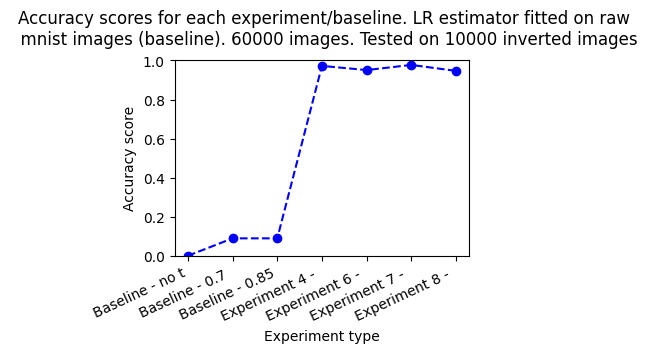

In [60]:
plt.plot([e[:15] for e in experiments[:3]+experiments[-4:]], scores_inv, linestyle='--', marker='o', color='b', label='Accuracy score')
plt.tight_layout(rect=(0., 0.03, 1., 0.86))
plt.suptitle(f"Accuracy scores for each experiment/baseline. LR estimator fitted on raw\n  mnist images (baseline). {data_train.shape[0]} images. Tested on {data_test.shape[0]} inverted images")
plt.ylim([.0, 1.])
plt.xlabel("Experiment type") 
plt.ylabel("Accuracy score") 
plt.xticks(rotation=25, ha='right')

### SVM

In [39]:
scores_inv_svm = []

#### Baseline - no thresholding - SVM

In [32]:
clfs_svm_inv_bl = SVC(kernel='rbf', C=svm_best_Cs["baseline"], gamma="auto")

score_inv_baseline_svm = score_inv_clf(clfs_svm_inv_bl, 
                                       train_flattened, 
                                       train_labels, 
                                       inv_test_flattened, 
                                       test_labels)

scores_inv_svm.append(score_inv_baseline_svm)
score_inv_baseline_svm

0.0008

#### Baseline - 0.7 threshold - SVM

In [35]:
clfs_svm_inv_bl_thr1 = SVC(kernel='rbf', C=svm_best_Cs["baseline"], gamma="auto")

scores_inv_baseline_svm_thr1 = score_inv_clf(clfs_svm_inv_bl_thr1, 
                                            train_flattened_inv_threshold1, 
                                            train_labels, 
                                            test_flattened_inv_threshold1, 
                                            test_labels)

scores_inv_svm.append(scores_inv_baseline_svm_thr1)
scores_inv_baseline_svm_thr1

0.0892

#### Baseline - 0.85 threshold - SVM

In [36]:
clfs_svm_inv_bl_thr2 = SVC(kernel='rbf', C=svm_best_Cs["baseline"], gamma="auto")

scores_inv_baseline_svm_thr2 = score_inv_clf(clfs_svm_inv_bl_thr2, 
                                            train_flattened_inv_threshold2, 
                                            train_labels, 
                                            test_flattened_inv_threshold2, 
                                            test_labels)

scores_inv_svm.append(scores_inv_baseline_svm_thr2)
scores_inv_baseline_svm_thr2

0.0892

#### Experiment 4 - SVM

In [37]:
clfs_svm_exp4_inv = SVC(kernel='rbf', C=svm_best_Cs["exp4"], gamma="auto")

scores_inv_exp4_svm = score_inv_clf(clfs_svm_exp4_inv, 
                                    exp4_train_img_inv, 
                                    train_labels, 
                                    exp_4_test_inv_transformed, 
                                    test_labels)

scores_inv_svm.append(scores_inv_exp4_svm)
scores_inv_exp4_svm

0.9832

#### Experiment 6 - SVM

In [40]:
clfs_svm_exp6_inv = SVC(kernel='rbf', C=svm_best_Cs["exp6"], gamma="auto")

scores_inv_exp6_svm = score_inv_clf(clfs_svm_exp6_inv, 
                                    exp6_train_img_inv, 
                                    train_labels, 
                                    exp_6_test_inv_transformed, 
                                    test_labels)

scores_inv_svm.append(scores_inv_exp6_svm)
scores_inv_exp6_svm

0.9624

#### Experiment 7 - SVM

In [41]:
clfs_svm_exp7_inv = SVC(kernel='rbf', C=svm_best_Cs["exp7"], gamma="auto")

scores_inv_exp7_svm = score_inv_clf(clfs_svm_exp7_inv, 
                                    exp7_train_img_inv, 
                                    train_labels, 
                                    exp_7_test_inv_transformed, 
                                    test_labels)

scores_inv_svm.append(scores_inv_exp7_svm)
scores_inv_exp7_svm

0.9758

#### Experiment 8 - SVM

In [42]:
clfs_svm_exp8_inv = SVC(kernel='rbf', C=svm_best_Cs["exp8"], gamma="auto")

scores_inv_exp8_svm = score_inv_clf(clfs_svm_exp8_inv, 
                                    exp8_train_img_inv, 
                                    train_labels, 
                                    exp_8_test_inv_transformed, 
                                    test_labels)

scores_inv_svm.append(scores_inv_exp8_svm)
scores_inv_exp8_svm

0.9658

#### Results SVM

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Baseline - no t'),
  Text(1, 0, 'Baseline - 0.7 '),
  Text(2, 0, 'Baseline - 0.85'),
  Text(3, 0, 'Experiment 4 - '),
  Text(4, 0, 'Experiment 6 - '),
  Text(5, 0, 'Experiment 7 - '),
  Text(6, 0, 'Experiment 8 - ')])

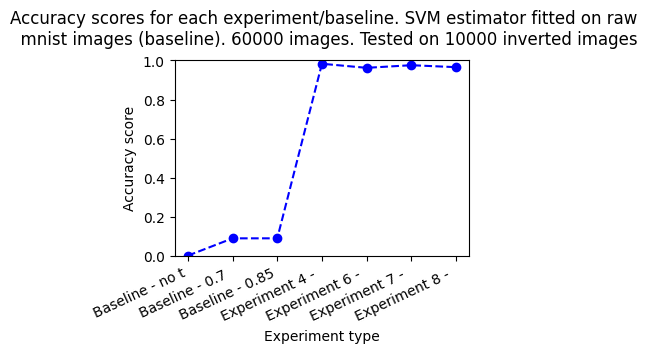

In [67]:
plt.plot([e[:15] for e in experiments[:3]+experiments[-4:]], scores_inv_svm, linestyle='--', marker='o', color='b', label='Accuracy score')
plt.tight_layout(rect=(0., 0.03, 1., 0.86))
plt.suptitle(f"Accuracy scores for each experiment/baseline. SVM estimator fitted on raw\n  mnist images (baseline). {data_train.shape[0]} images. Tested on {data_test.shape[0]} inverted images")
plt.ylim([.0, 1.])
plt.xlabel("Experiment type") 
plt.ylabel("Accuracy score") 
plt.xticks(rotation=25, ha='right')

### KNN

In [43]:
scores_inv_knn = []

#### Baseline - No thresholding - KNN

In [44]:
clfs_knn_inv_bl = KNeighborsClassifier(n_neighbors=5, p=2)

baseline_knn_score_inv = score_inv_clf(clfs_knn_inv_bl, 
                                        train_flattened, 
                                        train_labels, 
                                        inv_test_flattened,
                                        test_labels)

scores_inv_knn.append(baseline_knn_score_inv)
baseline_knn_score_inv

0.0669

#### Baseline - 0.7 threshold - KNN

In [45]:
clfs_knn_inv_bl_thr1 = KNeighborsClassifier(n_neighbors=5, p=2)
baseline_knn_score_inv_thr1 = score_inv_clf(clfs_knn_inv_bl_thr1, 
                                                train_flattened_inv_threshold1, 
                                                train_labels, 
                                                test_flattened_inv_threshold1, 
                                                test_labels)

scores_inv_knn.append(baseline_knn_score_inv_thr1)
baseline_knn_score_inv_thr1

0.1135

#### Baseline - 0.85 threshold - KNN

In [46]:
clfs_knn_inv_bl_thr2 = KNeighborsClassifier(n_neighbors=5, p=2)
baseline_knn_score_inv_thr2 = score_inv_clf(clfs_knn_inv_bl_thr2, 
                                                train_flattened_inv_threshold2, 
                                                train_labels, 
                                                test_flattened_inv_threshold2, 
                                                test_labels)

scores_inv_knn.append(baseline_knn_score_inv_thr2)
baseline_knn_score_inv_thr2

0.1135

#### Experiment 4 - KNN

In [47]:
clfs_knn_exp4_inv = KNeighborsClassifier(n_neighbors=5, p=2)

score_inv_exp4_knn = score_inv_clf(clfs_knn_exp4_inv,
                                    exp4_train_img_inv, 
                                    train_labels, 
                                    exp_4_test_inv_transformed, 
                                    test_labels)

scores_inv_knn.append(score_inv_exp4_knn)
score_inv_exp4_knn

0.9228

#### Experiment 6 - KNN

In [48]:
clfs_knn_exp6_inv = KNeighborsClassifier(n_neighbors=5, p=2)

score_inv_exp6_knn = score_inv_clf(clfs_knn_exp6_inv,
                                    exp6_train_img_inv, 
                                    train_labels, 
                                    exp_6_test_inv_transformed, 
                                    test_labels)

scores_inv_knn.append(score_inv_exp6_knn)
score_inv_exp6_knn

0.8518

#### Experiment 7 - KNN

In [49]:
clfs_knn_exp7_inv = KNeighborsClassifier(n_neighbors=5, p=2)

score_inv_exp7_knn = score_inv_clf(clfs_knn_exp7_inv,
                                    exp7_train_img_inv, 
                                    train_labels, 
                                    exp_7_test_inv_transformed, 
                                    test_labels)

scores_inv_knn.append(score_inv_exp7_knn)
score_inv_exp7_knn

0.9599

#### Experiment 8 - KNN

In [50]:
clfs_knn_exp8_inv = KNeighborsClassifier(n_neighbors=5, p=4)

score_inv_exp8_knn = score_inv_clf(clfs_knn_exp8_inv,
                                    exp8_train_img_inv, 
                                    train_labels, 
                                    exp_8_test_inv_transformed, 
                                    test_labels)

scores_inv_knn.append(score_inv_exp8_knn)
score_inv_exp8_knn

0.9163

#### Results KNN

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Baseline - no t'),
  Text(1, 0, 'Baseline - 0.7 '),
  Text(2, 0, 'Baseline - 0.85'),
  Text(3, 0, 'Experiment 4 - '),
  Text(4, 0, 'Experiment 6 - '),
  Text(5, 0, 'Experiment 7 - '),
  Text(6, 0, 'Experiment 8 - ')])

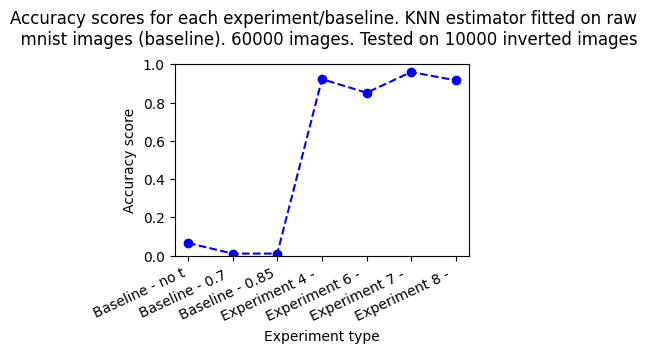

In [71]:
plt.plot([e[:15] for e in experiments[:3]+experiments[-4:]], scores_inv_knn, linestyle='--', marker='o', color='b', label='Accuracy score')
plt.tight_layout(rect=(0., 0.03, 1., 0.86))
plt.suptitle(f"Accuracy scores for each experiment/baseline. KNN estimator fitted on raw\n  mnist images (baseline). {data_train.shape[0]} images. Tested on {data_test.shape[0]} inverted images")
plt.ylim([.0, 1.])
plt.xlabel("Experiment type") 
plt.ylabel("Accuracy score") 
plt.xticks(rotation=25, ha='right')